# Regression ANN with best parameters
    find the best prediction window to apply with a rolling Nested CV technique

In [1]:
import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

dates = [2017010000,
         2017030000, 
         2017050000, 
         2017070000,
         2017090000, 
         2017110000,
         2018010000, 
         2018030000, 
         2018050000,
         2018070000,
         2018090000,
         2018110000]

dates_labels = ['24 ', 
                '22 ',
                '20 ',  
                '18 ', 
                '16 ', 
                '14 ', 
                '12 ',
                '10 ',
                '8 ',
                '6 ',
                '4 ',
                '2 ']

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

# Loop with model for 8 different data ranges (3 months intervals):

In [2]:
for i in dates:
    count = 0
    # data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    data = data.loc[data.index > i, :]
    
    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(method = 'ffill', inplace = True)
    y.fillna(method = 'ffill', inplace = True)
    
    X = X.astype('float64')
    X = X.round(20)
    
    # divide data into train and test with 20% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.1, shuffle=False)
    
    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    import keras
    from keras.models import Sequential # to initialise the NN
    from keras.layers import Dense # to create layers
    from keras.layers import Dropout
    from keras import initializers
    from keras import optimizers
    from keras.wrappers.scikit_learn import KerasRegressor
    
    # possible debug
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    def regressor_tunning(n_hidden = 4, 
                          n_neurons = 20, 
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        optimizer = optimizers.Adamax(lr = 0.001)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model
    
    tscv = TimeSeriesSplit(n_splits = 10)
    
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 100)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
192/192 [==============================] - 0s 2ms/step - loss: 16315.7363 - mse: 16315.7363 - mae: 117.0322
Epoch 2/100
192/192 [==============================] - 0s 2ms/step - loss: 5271.5718 - mse: 5271.5718 - mae: 52.7193
Epoch 3/100
192/192 [==============================] - 0s 2ms/step - loss: 3190.8225 - mse: 3190.8225 - mae: 39.3582
Epoch 4/100
192/192 [==============================] - 0s 2ms/step - loss: 3172.7415 - mse: 3172.7415 - mae: 39.5557
Epoch 5/100
192/192 [==============================] - 0s 2ms/step - loss: 3129.2683 - mse: 3129.2683 - mae: 39.1911
Epoch 6/100
192/192 [==============================] - 0s 2ms/step - loss: 3112.7327 - mse: 3112.7327 - mae: 38.8046
Epoch 7/100
192/192 [==============================] - 0s 2ms/step - loss: 3104.3367 - mse: 3104.3367 - mae: 39.0812
Epoch 8/100
192/192 [==============================] - 0s 2ms/step - loss: 2965.2520 - mse: 2965.2520 - mae: 37.9264
Epoch 9/100
192/192 [==============================] - 0s 2ms

383/383 [==============================] - 1s 2ms/step - loss: 2603.5986 - mse: 2603.5986 - mae: 33.4682
Epoch 40/100
383/383 [==============================] - 1s 2ms/step - loss: 2604.6846 - mse: 2604.6846 - mae: 33.4615
Epoch 41/100
383/383 [==============================] - 1s 2ms/step - loss: 2609.5388 - mse: 2609.5388 - mae: 33.2608
Epoch 42/100
383/383 [==============================] - 1s 2ms/step - loss: 2573.4692 - mse: 2573.4692 - mae: 33.4373
Epoch 43/100
383/383 [==============================] - 1s 2ms/step - loss: 2603.0833 - mse: 2603.0833 - mae: 33.1762
Epoch 44/100
383/383 [==============================] - 1s 2ms/step - loss: 2590.8796 - mse: 2590.8796 - mae: 33.2060
Epoch 45/100
383/383 [==============================] - 1s 2ms/step - loss: 2587.3345 - mse: 2587.3345 - mae: 33.5043
Epoch 46/100
383/383 [==============================] - 1s 2ms/step - loss: 2621.8059 - mse: 2621.8059 - mae: 33.3854
Epoch 47/100
383/383 [==============================] - 1s 2ms/step -

574/574 [==============================] - 1s 2ms/step - loss: 3075.4292 - mse: 3075.4292 - mae: 32.6354
Epoch 76/100
574/574 [==============================] - 1s 2ms/step - loss: 3061.0066 - mse: 3061.0066 - mae: 32.5435
Epoch 77/100
574/574 [==============================] - 1s 2ms/step - loss: 3143.1169 - mse: 3143.1169 - mae: 32.5119
Epoch 78/100
574/574 [==============================] - 1s 2ms/step - loss: 3238.5645 - mse: 3238.5645 - mae: 32.7548
Epoch 79/100
574/574 [==============================] - 1s 2ms/step - loss: 3104.6724 - mse: 3104.6724 - mae: 32.6536
Epoch 80/100
574/574 [==============================] - 1s 2ms/step - loss: 3118.7036 - mse: 3118.7036 - mae: 32.6246
Epoch 81/100
574/574 [==============================] - 1s 2ms/step - loss: 3032.0371 - mse: 3032.0371 - mae: 32.3879
Epoch 82/100
574/574 [==============================] - 1s 2ms/step - loss: 2915.1270 - mse: 2915.1270 - mae: 32.1844
Epoch 83/100
574/574 [==============================] - 1s 2ms/step -

956/956 [==============================] - 2s 2ms/step - loss: 2104.0503 - mse: 2104.0503 - mae: 28.4922
Epoch 13/100
956/956 [==============================] - 2s 2ms/step - loss: 2097.6770 - mse: 2097.6770 - mae: 28.4590
Epoch 14/100
956/956 [==============================] - 2s 2ms/step - loss: 2064.7070 - mse: 2064.7070 - mae: 28.3663
Epoch 15/100
956/956 [==============================] - 1s 2ms/step - loss: 2110.0173 - mse: 2110.0173 - mae: 28.5776
Epoch 16/100
956/956 [==============================] - 2s 2ms/step - loss: 2076.8467 - mse: 2076.8467 - mae: 28.3630
Epoch 17/100
956/956 [==============================] - 1s 2ms/step - loss: 2119.7375 - mse: 2119.7375 - mae: 28.4467
Epoch 18/100
956/956 [==============================] - 2s 2ms/step - loss: 2085.1545 - mse: 2085.1545 - mae: 28.3093
Epoch 19/100
956/956 [==============================] - 1s 2ms/step - loss: 2118.8083 - mse: 2118.8083 - mae: 28.4168
Epoch 20/100
956/956 [==============================] - 2s 2ms/step -

1147/1147 [==============================] - 2s 2ms/step - loss: 1885.3798 - mse: 1885.3798 - mae: 27.7266
Epoch 50/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1916.6884 - mse: 1916.6884 - mae: 27.7689
Epoch 51/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1920.8330 - mse: 1920.8330 - mae: 27.7042
Epoch 52/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1942.4489 - mse: 1942.4489 - mae: 27.8510
Epoch 53/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1896.3162 - mse: 1896.3162 - mae: 27.7169
Epoch 54/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1922.3229 - mse: 1922.3229 - mae: 27.7724
Epoch 55/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1872.1287 - mse: 1872.1287 - mae: 27.6672
Epoch 56/100
1147/1147 [==============================] - 2s 2ms/step - loss: 1909.1566 - mse: 1909.1566 - mae: 27.7651
Epoch 57/100
1147/1147 [=============================

1339/1339 [==============================] - 3s 2ms/step - loss: 1932.0085 - mse: 1932.0085 - mae: 27.7783
Epoch 85/100
1339/1339 [==============================] - 2s 2ms/step - loss: 1911.9487 - mse: 1911.9487 - mae: 27.7413
Epoch 86/100
1339/1339 [==============================] - 2s 2ms/step - loss: 1888.2986 - mse: 1888.2986 - mae: 27.6149
Epoch 87/100
1339/1339 [==============================] - 2s 2ms/step - loss: 1932.0513 - mse: 1932.0513 - mae: 27.7485
Epoch 88/100
1339/1339 [==============================] - 3s 2ms/step - loss: 1912.7952 - mse: 1912.7952 - mae: 27.7267
Epoch 89/100
1339/1339 [==============================] - 2s 2ms/step - loss: 1892.7234 - mse: 1892.7234 - mae: 27.5971: 0s - loss: 1954.3571 - mse: 1954
Epoch 90/100
1339/1339 [==============================] - 2s 2ms/step - loss: 1915.1085 - mse: 1915.1088 - mae: 27.7297
Epoch 91/100
1339/1339 [==============================] - 3s 2ms/step - loss: 1905.6715 - mse: 1905.6715 - mae: 27.5834
Epoch 92/100
1339/1

1721/1721 [==============================] - 3s 2ms/step - loss: 2019.1124 - mse: 2019.1124 - mae: 28.0839
Epoch 20/100
1721/1721 [==============================] - 3s 2ms/step - loss: 2110.0649 - mse: 2110.0649 - mae: 28.1684
Epoch 21/100
1721/1721 [==============================] - 3s 2ms/step - loss: 1989.2053 - mse: 1989.2053 - mae: 28.0328
Epoch 22/100
1721/1721 [==============================] - 3s 2ms/step - loss: 2066.3440 - mse: 2066.3440 - mae: 28.0614
Epoch 23/100
1721/1721 [==============================] - 3s 2ms/step - loss: 2078.5320 - mse: 2078.5320 - mae: 28.1644
Epoch 24/100
1721/1721 [==============================] - 3s 2ms/step - loss: 2022.0308 - mse: 2022.0308 - mae: 28.0279
Epoch 25/100
1721/1721 [==============================] - 3s 2ms/step - loss: 2042.9918 - mse: 2042.9918 - mae: 28.0433
Epoch 26/100
1721/1721 [==============================] - 3s 2ms/step - loss: 1994.2756 - mse: 1994.2756 - mae: 28.0344
Epoch 27/100
1721/1721 [=============================

1912/1912 [==============================] - 3s 2ms/step - loss: 1943.7592 - mse: 1943.7592 - mae: 27.6289
Epoch 55/100
1912/1912 [==============================] - 3s 2ms/step - loss: 1901.2726 - mse: 1901.2726 - mae: 27.6804
Epoch 56/100
1912/1912 [==============================] - 3s 2ms/step - loss: 1897.5439 - mse: 1897.5439 - mae: 27.5466
Epoch 57/100
1912/1912 [==============================] - 4s 2ms/step - loss: 1919.3162 - mse: 1919.3162 - mae: 27.7156
Epoch 58/100
1912/1912 [==============================] - 4s 2ms/step - loss: 1942.0662 - mse: 1942.0662 - mae: 27.6904
Epoch 59/100
1912/1912 [==============================] - 4s 2ms/step - loss: 1888.9043 - mse: 1888.9043 - mae: 27.6034
Epoch 60/100
1912/1912 [==============================] - 4s 2ms/step - loss: 1979.1370 - mse: 1979.1370 - mae: 27.6382
Epoch 61/100
1912/1912 [==============================] - 3s 2ms/step - loss: 1874.1262 - mse: 1874.1262 - mae: 27.5382
Epoch 62/100
1912/1912 [=============================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
176/176 [==============================] - 0s 2ms/step - loss: 14453.6533 - mse: 14453.6533 - mae: 105.8618
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 4238.4194 - mse: 4238.4194 - mae: 42.0286
Epoch 3/100
176/176 [==============================] - 0s 1ms/step - loss: 3605.7253 - mse: 3605.7253 - mae: 37.1386
Epoch 4/100
176/176 [==============================] - 0s 1ms/step - loss: 3694.7739 - mse: 3694.7739 - mae: 37.2852
Epoch 5/100
176/176 [==============================] - 0s 1ms/step - loss: 3590.2664 - mse: 3590.2664 - mae: 36.8172
Epoch 6/100
176/176 [==============================] - 0s 1ms/step - loss: 3677.6787 - mse: 3677.6787 - mae: 37.6181
Epoch 7/100
176/176 [==============================] - 0s 1ms/step - loss: 3571.3000 - mse: 3571.3000 - mae: 37.0919
Epoch 8/100
176/176 [==============================] - 0s 1ms/step - loss: 3502.7341 - mse: 3502.7341 - mae: 36.9003
Epoch 9/100
176/176 [==============================] - 0s 1ms

176/176 [==============================] - 0s 2ms/step - loss: 3004.5251 - mse: 3004.5251 - mae: 34.0788
Epoch 71/100
176/176 [==============================] - 0s 2ms/step - loss: 3049.4209 - mse: 3049.4207 - mae: 33.9249
Epoch 72/100
176/176 [==============================] - 0s 3ms/step - loss: 2961.2148 - mse: 2961.2148 - mae: 33.3728
Epoch 73/100
176/176 [==============================] - 0s 3ms/step - loss: 3026.8499 - mse: 3026.8496 - mae: 33.7779
Epoch 74/100
176/176 [==============================] - 0s 2ms/step - loss: 2929.4246 - mse: 2929.4246 - mae: 33.6104
Epoch 75/100
176/176 [==============================] - 0s 2ms/step - loss: 3005.5046 - mse: 3005.5046 - mae: 33.8725
Epoch 76/100
176/176 [==============================] - 0s 2ms/step - loss: 2823.7256 - mse: 2823.7256 - mae: 33.1540
Epoch 77/100
176/176 [==============================] - 0s 2ms/step - loss: 2931.1304 - mse: 2931.1304 - mae: 33.1202
Epoch 78/100
176/176 [==============================] - 0s 2ms/step -

528/528 [==============================] - 1s 2ms/step - loss: 3053.7361 - mse: 3053.7361 - mae: 30.7519
Epoch 9/100
528/528 [==============================] - 1s 2ms/step - loss: 3036.1023 - mse: 3036.1023 - mae: 30.4409
Epoch 10/100
528/528 [==============================] - 1s 2ms/step - loss: 2863.7686 - mse: 2863.7686 - mae: 30.4541
Epoch 11/100
528/528 [==============================] - 1s 2ms/step - loss: 3070.4358 - mse: 3070.4358 - mae: 30.6598
Epoch 12/100
528/528 [==============================] - 1s 2ms/step - loss: 3211.1145 - mse: 3211.1145 - mae: 30.8973
Epoch 13/100
528/528 [==============================] - 1s 2ms/step - loss: 2997.5559 - mse: 2997.5559 - mae: 30.6273
Epoch 14/100
528/528 [==============================] - 2s 3ms/step - loss: 2977.9238 - mse: 2977.9238 - mae: 30.3686
Epoch 15/100
528/528 [==============================] - 1s 3ms/step - loss: 2988.1729 - mse: 2988.1729 - mae: 30.4604
Epoch 16/100
528/528 [==============================] - 1s 2ms/step - 

703/703 [==============================] - 1s 1ms/step - loss: 2072.5564 - mse: 2072.5564 - mae: 27.6189
Epoch 47/100
703/703 [==============================] - 1s 2ms/step - loss: 2052.9817 - mse: 2052.9817 - mae: 27.2864
Epoch 48/100
703/703 [==============================] - 1s 1ms/step - loss: 2018.1212 - mse: 2018.1212 - mae: 27.2396
Epoch 49/100
703/703 [==============================] - 1s 2ms/step - loss: 2111.5891 - mse: 2111.5891 - mae: 27.6168
Epoch 50/100
703/703 [==============================] - 1s 2ms/step - loss: 2095.1765 - mse: 2095.1765 - mae: 27.4412
Epoch 51/100
703/703 [==============================] - 1s 2ms/step - loss: 2049.1985 - mse: 2049.1985 - mae: 27.3794
Epoch 52/100
703/703 [==============================] - 1s 1ms/step - loss: 2116.4868 - mse: 2116.4868 - mae: 27.5460
Epoch 53/100
703/703 [==============================] - 1s 1ms/step - loss: 2083.4553 - mse: 2083.4553 - mae: 27.4449
Epoch 54/100
703/703 [==============================] - 1s 2ms/step -

879/879 [==============================] - 2s 2ms/step - loss: 1850.2921 - mse: 1850.2921 - mae: 26.7826
Epoch 85/100
879/879 [==============================] - 2s 2ms/step - loss: 1912.0082 - mse: 1912.0082 - mae: 26.7053
Epoch 86/100
879/879 [==============================] - 2s 2ms/step - loss: 1837.5394 - mse: 1837.5394 - mae: 26.7171
Epoch 87/100
879/879 [==============================] - 1s 2ms/step - loss: 1858.4507 - mse: 1858.4507 - mae: 26.6822
Epoch 88/100
879/879 [==============================] - 2s 2ms/step - loss: 1866.1920 - mse: 1866.1920 - mae: 26.8752
Epoch 89/100
879/879 [==============================] - 2s 2ms/step - loss: 1829.5955 - mse: 1829.5955 - mae: 26.6718
Epoch 90/100
879/879 [==============================] - 2s 2ms/step - loss: 1854.1469 - mse: 1854.1469 - mae: 26.7240
Epoch 91/100
879/879 [==============================] - 2s 2ms/step - loss: 1900.1583 - mse: 1900.1583 - mae: 26.8761
Epoch 92/100
879/879 [==============================] - 2s 2ms/step -

1230/1230 [==============================] - 2s 1ms/step - loss: 2344.1890 - mse: 2344.1890 - mae: 28.7517
Epoch 21/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2305.0803 - mse: 2305.0806 - mae: 28.5841
Epoch 22/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2285.7446 - mse: 2285.7446 - mae: 28.4687
Epoch 23/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2261.0461 - mse: 2261.0461 - mae: 28.6044
Epoch 24/100
1230/1230 [==============================] - 2s 2ms/step - loss: 2273.1873 - mse: 2273.1873 - mae: 28.3992
Epoch 25/100
1230/1230 [==============================] - 2s 2ms/step - loss: 2248.7761 - mse: 2248.7759 - mae: 28.6253
Epoch 26/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2265.8171 - mse: 2265.8171 - mae: 28.4678
Epoch 27/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2345.5183 - mse: 2345.5183 - mae: 28.4331
Epoch 28/100
1230/1230 [=============================

Epoch 88/100
1230/1230 [==============================] - 2s 2ms/step - loss: 2177.8594 - mse: 2177.8594 - mae: 28.2756
Epoch 89/100
1230/1230 [==============================] - 2s 2ms/step - loss: 2142.9575 - mse: 2142.9575 - mae: 28.1939
Epoch 90/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2213.4055 - mse: 2213.4055 - mae: 28.2591
Epoch 91/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2162.7432 - mse: 2162.7432 - mae: 28.3099
Epoch 92/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2232.3921 - mse: 2232.3921 - mae: 28.3688
Epoch 93/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2189.3953 - mse: 2189.3953 - mae: 28.3165
Epoch 94/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2208.5237 - mse: 2208.5237 - mae: 28.3524
Epoch 95/100
1230/1230 [==============================] - 2s 1ms/step - loss: 2191.1584 - mse: 2191.1584 - mae: 28.3626: 0s - loss: 231
Epoch 96/100
1230/1230 [

1582/1582 [==============================] - 3s 2ms/step - loss: 1958.2651 - mse: 1958.2651 - mae: 27.5104
Epoch 25/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1884.3469 - mse: 1884.3469 - mae: 27.3417
Epoch 26/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1949.9688 - mse: 1949.9688 - mae: 27.4349
Epoch 27/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1943.5636 - mse: 1943.5636 - mae: 27.4000
Epoch 28/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1908.4014 - mse: 1908.4014 - mae: 27.5118
Epoch 29/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1996.9263 - mse: 1996.9263 - mae: 27.5297
Epoch 30/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1938.1719 - mse: 1938.1720 - mae: 27.4517
Epoch 31/100
1582/1582 [==============================] - 3s 2ms/step - loss: 1937.1708 - mse: 1937.1708 - mae: 27.4608
Epoch 32/100
1582/1582 [=============================

1757/1757 [==============================] - 2s 1ms/step - loss: 1846.2986 - mse: 1846.2986 - mae: 26.9459
Epoch 61/100
1757/1757 [==============================] - 2s 1ms/step - loss: 1849.6034 - mse: 1849.6034 - mae: 27.1011
Epoch 62/100
1757/1757 [==============================] - 3s 2ms/step - loss: 1915.9537 - mse: 1915.9537 - mae: 27.1533
Epoch 63/100
1757/1757 [==============================] - 3s 1ms/step - loss: 1875.2695 - mse: 1875.2695 - mae: 27.1581
Epoch 64/100
1757/1757 [==============================] - 3s 2ms/step - loss: 1908.6849 - mse: 1908.6849 - mae: 27.2596
Epoch 65/100
1757/1757 [==============================] - 2s 1ms/step - loss: 1870.5822 - mse: 1870.5822 - mae: 27.0433
Epoch 66/100
1757/1757 [==============================] - 2s 1ms/step - loss: 1869.6523 - mse: 1869.6523 - mae: 27.1650
Epoch 67/100
1757/1757 [==============================] - 2s 1ms/step - loss: 1881.4186 - mse: 1881.4186 - mae: 27.0908
Epoch 68/100
1757/1757 [=============================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
161/161 [==============================] - 0s 2ms/step - loss: 19881.4395 - mse: 19881.4395 - mae: 105.5463
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 11574.8398 - mse: 11574.8398 - mae: 53.2559
Epoch 3/100
161/161 [==============================] - 0s 2ms/step - loss: 9465.1289 - mse: 9465.1289 - mae: 40.7703
Epoch 4/100
161/161 [==============================] - 0s 2ms/step - loss: 9271.9014 - mse: 9271.9014 - mae: 39.9458
Epoch 5/100
161/161 [==============================] - 0s 2ms/step - loss: 9162.8848 - mse: 9162.8848 - mae: 40.8657
Epoch 6/100
161/161 [==============================] - 0s 2ms/step - loss: 9211.5088 - mse: 9211.5088 - mae: 40.9813
Epoch 7/100
161/161 [==============================] - 0s 1ms/step - loss: 9220.8076 - mse: 9220.8076 - mae: 39.5957
Epoch 8/100
161/161 [==============================] - 0s 2ms/step - loss: 9172.2559 - mse: 9172.2559 - mae: 40.5192
Epoch 9/100
161/161 [==============================] - 0s 2

161/161 [==============================] - 0s 2ms/step - loss: 7441.5161 - mse: 7441.5161 - mae: 38.5368
Epoch 71/100
161/161 [==============================] - 0s 2ms/step - loss: 7257.4053 - mse: 7257.4053 - mae: 39.5566
Epoch 72/100
161/161 [==============================] - 0s 2ms/step - loss: 7501.2085 - mse: 7501.2085 - mae: 38.6970
Epoch 73/100
161/161 [==============================] - 0s 2ms/step - loss: 6972.0464 - mse: 6972.0464 - mae: 37.9595
Epoch 74/100
161/161 [==============================] - 0s 2ms/step - loss: 7413.6333 - mse: 7413.6333 - mae: 38.8360
Epoch 75/100
161/161 [==============================] - 0s 2ms/step - loss: 7089.0029 - mse: 7089.0029 - mae: 39.1239
Epoch 76/100
161/161 [==============================] - 0s 2ms/step - loss: 7142.9224 - mse: 7142.9224 - mae: 38.8962
Epoch 77/100
161/161 [==============================] - 0s 2ms/step - loss: 7515.8862 - mse: 7515.8862 - mae: 38.7461
Epoch 78/100
161/161 [==============================] - 0s 2ms/step -

320/320 [==============================] - 1s 2ms/step - loss: 2862.7461 - mse: 2862.7461 - mae: 30.1294
Epoch 40/100
320/320 [==============================] - 1s 2ms/step - loss: 3146.2759 - mse: 3146.2756 - mae: 30.5528
Epoch 41/100
320/320 [==============================] - 1s 2ms/step - loss: 2850.0889 - mse: 2850.0889 - mae: 29.7376
Epoch 42/100
320/320 [==============================] - 1s 2ms/step - loss: 2971.2026 - mse: 2971.2026 - mae: 29.9967
Epoch 43/100
320/320 [==============================] - 1s 2ms/step - loss: 2817.2383 - mse: 2817.2383 - mae: 29.8817
Epoch 44/100
320/320 [==============================] - 1s 2ms/step - loss: 2897.3438 - mse: 2897.3438 - mae: 29.7902
Epoch 45/100
320/320 [==============================] - 1s 2ms/step - loss: 3064.1335 - mse: 3064.1335 - mae: 30.1410
Epoch 46/100
320/320 [==============================] - 1s 2ms/step - loss: 2936.3162 - mse: 2936.3162 - mae: 29.7624
Epoch 47/100
320/320 [==============================] - 1s 3ms/step -

480/480 [==============================] - 1s 1ms/step - loss: 2059.6448 - mse: 2059.6448 - mae: 27.3189
Epoch 9/100
480/480 [==============================] - 1s 2ms/step - loss: 2074.2080 - mse: 2074.2080 - mae: 27.4197
Epoch 10/100
480/480 [==============================] - 1s 1ms/step - loss: 2076.6235 - mse: 2076.6235 - mae: 27.0638
Epoch 11/100
480/480 [==============================] - 1s 1ms/step - loss: 2089.6211 - mse: 2089.6211 - mae: 27.2552
Epoch 12/100
480/480 [==============================] - 1s 1ms/step - loss: 2054.2891 - mse: 2054.2891 - mae: 26.9869
Epoch 13/100
480/480 [==============================] - 1s 1ms/step - loss: 2119.9172 - mse: 2119.9172 - mae: 27.4436
Epoch 14/100
480/480 [==============================] - 1s 1ms/step - loss: 2084.3982 - mse: 2084.3982 - mae: 27.2526
Epoch 15/100
480/480 [==============================] - 1s 2ms/step - loss: 2227.5793 - mse: 2227.5793 - mae: 27.4129
Epoch 16/100
480/480 [==============================] - 1s 1ms/step - 

640/640 [==============================] - 1s 2ms/step - loss: 1728.9310 - mse: 1728.9310 - mae: 26.2977
Epoch 46/100
640/640 [==============================] - 1s 2ms/step - loss: 1739.3123 - mse: 1739.3123 - mae: 26.2780
Epoch 47/100
640/640 [==============================] - 1s 2ms/step - loss: 1707.0386 - mse: 1707.0386 - mae: 26.1106
Epoch 48/100
640/640 [==============================] - 1s 2ms/step - loss: 1744.8131 - mse: 1744.8131 - mae: 26.1392
Epoch 49/100
640/640 [==============================] - 1s 2ms/step - loss: 1731.4471 - mse: 1731.4471 - mae: 26.1294
Epoch 50/100
640/640 [==============================] - 1s 2ms/step - loss: 1761.5879 - mse: 1761.5879 - mae: 26.0570: 0s - loss: 204
Epoch 51/100
640/640 [==============================] - 1s 1ms/step - loss: 1713.2314 - mse: 1713.2314 - mae: 26.0901
Epoch 52/100
640/640 [==============================] - 1s 1ms/step - loss: 1803.2394 - mse: 1803.2394 - mae: 26.3434
Epoch 53/100
640/640 [==============================]

799/799 [==============================] - 1s 1ms/step - loss: 1617.4562 - mse: 1617.4562 - mae: 25.8599
Epoch 84/100
799/799 [==============================] - 1s 1ms/step - loss: 1589.4304 - mse: 1589.4304 - mae: 25.8828
Epoch 85/100
799/799 [==============================] - 1s 1ms/step - loss: 1637.9241 - mse: 1637.9241 - mae: 26.0727
Epoch 86/100
799/799 [==============================] - 1s 2ms/step - loss: 1648.0164 - mse: 1648.0164 - mae: 25.9634
Epoch 87/100
799/799 [==============================] - 1s 1ms/step - loss: 1587.1742 - mse: 1587.1742 - mae: 25.6503
Epoch 88/100
799/799 [==============================] - 1s 1ms/step - loss: 1575.8087 - mse: 1575.8087 - mae: 25.6479
Epoch 89/100
799/799 [==============================] - 1s 1ms/step - loss: 1570.1073 - mse: 1570.1073 - mae: 25.7414
Epoch 90/100
799/799 [==============================] - 1s 1ms/step - loss: 1655.9518 - mse: 1655.9518 - mae: 25.7248
Epoch 91/100
799/799 [==============================] - 1s 1ms/step -

1119/1119 [==============================] - 1s 1ms/step - loss: 2261.7207 - mse: 2261.7207 - mae: 28.4294: 1s -
Epoch 22/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2305.6208 - mse: 2305.6208 - mae: 28.4341
Epoch 23/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2300.0415 - mse: 2300.0415 - mae: 28.4816
Epoch 24/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2221.8037 - mse: 2221.8037 - mae: 28.3697
Epoch 25/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2259.6033 - mse: 2259.6033 - mae: 28.4473
Epoch 26/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2232.8296 - mse: 2232.8296 - mae: 28.4398
Epoch 27/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2326.2114 - mse: 2326.2114 - mae: 28.5070
Epoch 28/100
1119/1119 [==============================] - 2s 2ms/step - loss: 2230.8152 - mse: 2230.8152 - mae: 28.3579
Epoch 29/100
1119/1119 [=======================

1278/1278 [==============================] - 2s 1ms/step - loss: 1991.2484 - mse: 1991.2484 - mae: 27.5524
Epoch 56/100
1278/1278 [==============================] - 2s 1ms/step - loss: 1956.0559 - mse: 1956.0559 - mae: 27.3898
Epoch 57/100
1278/1278 [==============================] - 2s 1ms/step - loss: 2006.5319 - mse: 2006.5319 - mae: 27.5131
Epoch 58/100
1278/1278 [==============================] - 2s 1ms/step - loss: 2006.9451 - mse: 2006.9451 - mae: 27.6354
Epoch 59/100
1278/1278 [==============================] - 1s 1ms/step - loss: 1961.4218 - mse: 1961.4218 - mae: 27.4818
Epoch 60/100
1278/1278 [==============================] - 2s 1ms/step - loss: 1911.1367 - mse: 1911.1367 - mae: 27.2838
Epoch 61/100
1278/1278 [==============================] - 2s 1ms/step - loss: 2012.9851 - mse: 2012.9851 - mae: 27.5063
Epoch 62/100
1278/1278 [==============================] - 2s 1ms/step - loss: 1982.5621 - mse: 1982.5621 - mae: 27.5722
Epoch 63/100
1278/1278 [=============================

1438/1438 [==============================] - 2s 2ms/step - loss: 1835.7640 - mse: 1835.7640 - mae: 26.9115
Epoch 91/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1856.6152 - mse: 1856.6152 - mae: 26.9610
Epoch 92/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1823.7023 - mse: 1823.7023 - mae: 26.8320
Epoch 93/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1856.5706 - mse: 1856.5706 - mae: 26.9417
Epoch 94/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1849.8485 - mse: 1849.8485 - mae: 26.8707
Epoch 95/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1875.5823 - mse: 1875.5822 - mae: 26.8373
Epoch 96/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1843.5048 - mse: 1843.5048 - mae: 26.8111
Epoch 97/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1823.0841 - mse: 1823.0841 - mae: 26.8570
Epoch 98/100
1438/1438 [=============================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
144/144 [==============================] - 0s 970us/step - loss: 11754.5752 - mse: 11754.5752 - mae: 104.2382
Epoch 2/100
144/144 [==============================] - 0s 970us/step - loss: 4804.0376 - mse: 4804.0376 - mae: 57.6725
Epoch 3/100
144/144 [==============================] - 0s 914us/step - loss: 1488.9279 - mse: 1488.9279 - mae: 29.8720
Epoch 4/100
144/144 [==============================] - 0s 1ms/step - loss: 1471.6318 - mse: 1471.6318 - mae: 30.0908
Epoch 5/100
144/144 [==============================] - 0s 935us/step - loss: 1412.7126 - mse: 1412.7126 - mae: 29.1819
Epoch 6/100
144/144 [==============================] - 0s 963us/step - loss: 1430.4083 - mse: 1430.4083 - mae: 29.1921
Epoch 7/100
144/144 [==============================] - 0s 887us/step - loss: 1331.8108 - mse: 1331.8108 - mae: 28.5664
Epoch 8/100
144/144 [==============================] - 0s 880us/step - loss: 1359.5988 - mse: 1359.5988 - mae: 28.9140
Epoch 9/100
144/144 [==========================

288/288 [==============================] - 0s 1ms/step - loss: 944.5299 - mse: 944.5299 - mae: 23.9471
Epoch 39/100
288/288 [==============================] - 0s 1ms/step - loss: 931.1114 - mse: 931.1114 - mae: 23.7814
Epoch 40/100
288/288 [==============================] - 0s 1ms/step - loss: 942.8985 - mse: 942.8985 - mae: 23.8968
Epoch 41/100
288/288 [==============================] - 0s 1ms/step - loss: 958.3257 - mse: 958.3257 - mae: 24.0872
Epoch 42/100
288/288 [==============================] - 0s 1ms/step - loss: 932.2697 - mse: 932.2697 - mae: 23.7820
Epoch 43/100
288/288 [==============================] - 0s 1ms/step - loss: 955.2186 - mse: 955.2186 - mae: 23.9282
Epoch 44/100
288/288 [==============================] - 0s 1ms/step - loss: 916.2939 - mse: 916.2939 - mae: 23.6625
Epoch 45/100
288/288 [==============================] - 0s 1ms/step - loss: 946.9592 - mse: 946.9592 - mae: 24.0884
Epoch 46/100
288/288 [==============================] - 0s 1ms/step - loss: 931.8464 

432/432 [==============================] - 1s 1ms/step - loss: 957.6061 - mse: 957.6061 - mae: 23.7298
Epoch 79/100
432/432 [==============================] - 1s 2ms/step - loss: 952.0849 - mse: 952.0849 - mae: 23.7241
Epoch 80/100
432/432 [==============================] - 1s 2ms/step - loss: 965.4656 - mse: 965.4656 - mae: 23.9019
Epoch 81/100
432/432 [==============================] - 1s 1ms/step - loss: 958.1380 - mse: 958.1380 - mae: 23.7777
Epoch 82/100
432/432 [==============================] - 1s 1ms/step - loss: 960.0544 - mse: 960.0544 - mae: 23.7755
Epoch 83/100
432/432 [==============================] - 1s 1ms/step - loss: 957.8999 - mse: 957.8999 - mae: 23.7483
Epoch 84/100
432/432 [==============================] - 1s 1ms/step - loss: 981.6323 - mse: 981.6323 - mae: 24.0910
Epoch 85/100
432/432 [==============================] - 1s 1ms/step - loss: 956.0703 - mse: 956.0703 - mae: 23.7843
Epoch 86/100
432/432 [==============================] - 1s 1ms/step - loss: 958.0421 

719/719 [==============================] - 1s 2ms/step - loss: 1266.1344 - mse: 1266.1344 - mae: 24.9450
Epoch 17/100
719/719 [==============================] - 1s 1ms/step - loss: 1261.3983 - mse: 1261.3983 - mae: 24.9852
Epoch 18/100
719/719 [==============================] - 1s 2ms/step - loss: 1254.3088 - mse: 1254.3088 - mae: 24.9470
Epoch 19/100
719/719 [==============================] - 1s 2ms/step - loss: 1257.9219 - mse: 1257.9219 - mae: 24.9205
Epoch 20/100
719/719 [==============================] - 1s 2ms/step - loss: 1263.0353 - mse: 1263.0353 - mae: 24.9967
Epoch 21/100
719/719 [==============================] - 1s 2ms/step - loss: 1254.9926 - mse: 1254.9926 - mae: 24.9402
Epoch 22/100
719/719 [==============================] - 1s 2ms/step - loss: 1266.5601 - mse: 1266.5601 - mae: 24.8780
Epoch 23/100
719/719 [==============================] - 1s 1ms/step - loss: 1257.7552 - mse: 1257.7552 - mae: 24.9490
Epoch 24/100
719/719 [==============================] - 1s 1ms/step -

863/863 [==============================] - 1s 2ms/step - loss: 1821.5083 - mse: 1821.5083 - mae: 27.5428
Epoch 55/100
863/863 [==============================] - 2s 2ms/step - loss: 1884.2345 - mse: 1884.2345 - mae: 27.7047
Epoch 56/100
863/863 [==============================] - 2s 2ms/step - loss: 1825.9978 - mse: 1825.9978 - mae: 27.4575
Epoch 57/100
863/863 [==============================] - 2s 2ms/step - loss: 1840.2805 - mse: 1840.2805 - mae: 27.5340
Epoch 58/100
863/863 [==============================] - 1s 2ms/step - loss: 1839.0621 - mse: 1839.0621 - mae: 27.7758
Epoch 59/100
863/863 [==============================] - 2s 2ms/step - loss: 1896.4884 - mse: 1896.4884 - mae: 27.6776
Epoch 60/100
863/863 [==============================] - 1s 2ms/step - loss: 1820.3300 - mse: 1820.3300 - mae: 27.5810
Epoch 61/100
863/863 [==============================] - 1s 2ms/step - loss: 1833.2643 - mse: 1833.2643 - mae: 27.6000
Epoch 62/100
863/863 [==============================] - 1s 2ms/step -

Epoch 23/100
1007/1007 [==============================] - 1s 1ms/step - loss: 1758.6481 - mse: 1758.6481 - mae: 27.3875
Epoch 24/100
1007/1007 [==============================] - 1s 1ms/step - loss: 1763.6982 - mse: 1763.6982 - mae: 27.4871
Epoch 25/100
1007/1007 [==============================] - 1s 1ms/step - loss: 1749.1908 - mse: 1749.1908 - mae: 27.4460
Epoch 26/100
1007/1007 [==============================] - 1s 1ms/step - loss: 1765.9343 - mse: 1765.9343 - mae: 27.3710
Epoch 27/100
1007/1007 [==============================] - 1s 1ms/step - loss: 1733.3671 - mse: 1733.3671 - mae: 27.3394
Epoch 28/100
1007/1007 [==============================] - 2s 2ms/step - loss: 1716.4015 - mse: 1716.4015 - mae: 27.2873
Epoch 29/100
1007/1007 [==============================] - 2s 2ms/step - loss: 1763.2777 - mse: 1763.2777 - mae: 27.3231
Epoch 30/100
1007/1007 [==============================] - ETA: 0s - loss: 1771.9106 - mse: 1771.9106 - mae: 27.36 - 1s 1ms/step - loss: 1760.2837 - mse: 1760.28

1151/1151 [==============================] - 1s 1ms/step - loss: 1593.2058 - mse: 1593.2058 - mae: 26.3427
Epoch 59/100
1151/1151 [==============================] - 1s 1ms/step - loss: 1654.1285 - mse: 1654.1285 - mae: 26.3494
Epoch 60/100
1151/1151 [==============================] - 1s 1ms/step - loss: 1602.2262 - mse: 1602.2262 - mae: 26.3822
Epoch 61/100
1151/1151 [==============================] - 1s 1ms/step - loss: 1654.4568 - mse: 1654.4569 - mae: 26.3390
Epoch 62/100
1151/1151 [==============================] - 1s 1ms/step - loss: 1601.6256 - mse: 1601.6256 - mae: 26.3920
Epoch 63/100
1151/1151 [==============================] - 1s 1ms/step - loss: 1590.2385 - mse: 1590.2385 - mae: 26.3997
Epoch 64/100
1151/1151 [==============================] - 1s 1ms/step - loss: 1692.8035 - mse: 1692.8035 - mae: 26.3849
Epoch 65/100
1151/1151 [==============================] - 2s 2ms/step - loss: 1554.1842 - mse: 1554.1842 - mae: 26.2578
Epoch 66/100
1151/1151 [=============================

1294/1294 [==============================] - 2s 1ms/step - loss: 1544.1620 - mse: 1544.1620 - mae: 26.0644
Epoch 95/100
1294/1294 [==============================] - 2s 1ms/step - loss: 1523.6759 - mse: 1523.6759 - mae: 25.9897
Epoch 96/100
1294/1294 [==============================] - 2s 1ms/step - loss: 1496.5682 - mse: 1496.5682 - mae: 25.8930
Epoch 97/100
1294/1294 [==============================] - 2s 1ms/step - loss: 1559.6774 - mse: 1559.6774 - mae: 25.8991
Epoch 98/100
1294/1294 [==============================] - 2s 1ms/step - loss: 1557.0684 - mse: 1557.0684 - mae: 25.9404
Epoch 99/100
1294/1294 [==============================] - 2s 1ms/step - loss: 1514.4296 - mse: 1514.4296 - mae: 25.9850
Epoch 100/100
1294/1294 [==============================] - 2s 1ms/step - loss: 1506.0344 - mse: 1506.0344 - mae: 25.8524
9
Epoch 1/100
1438/1438 [==============================] - 2s 1ms/step - loss: 1677.6501 - mse: 1677.6501 - mae: 26.2366
Epoch 2/100
1438/1438 [============================

1438/1438 [==============================] - 3s 2ms/step - loss: 1650.8153 - mse: 1650.8153 - mae: 26.1698
Epoch 63/100
1438/1438 [==============================] - 3s 2ms/step - loss: 1642.3823 - mse: 1642.3823 - mae: 26.1777
Epoch 64/100
1438/1438 [==============================] - 3s 2ms/step - loss: 1597.3145 - mse: 1597.3145 - mae: 26.1084
Epoch 65/100
1438/1438 [==============================] - 3s 2ms/step - loss: 1634.6458 - mse: 1634.6458 - mae: 26.1643
Epoch 66/100
1438/1438 [==============================] - 3s 2ms/step - loss: 1621.6083 - mse: 1621.6083 - mae: 26.1728
Epoch 67/100
1438/1438 [==============================] - 4s 2ms/step - loss: 1607.1852 - mse: 1607.1852 - mae: 26.2561
Epoch 68/100
1438/1438 [==============================] - 3s 2ms/step - loss: 1675.4849 - mse: 1675.4849 - mae: 26.1847
Epoch 69/100
1438/1438 [==============================] - 3s 2ms/step - loss: 1651.0753 - mse: 1651.0753 - mae: 26.2660
Epoch 70/100
1438/1438 [=============================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
129/129 [==============================] - 0s 734us/step - loss: 11623.2568 - mse: 11623.2568 - mae: 102.4381
Epoch 2/100
129/129 [==============================] - 0s 905us/step - loss: 3598.2117 - mse: 3598.2117 - mae: 48.1348
Epoch 3/100
129/129 [==============================] - 0s 796us/step - loss: 1602.2482 - mse: 1602.2482 - mae: 30.8399
Epoch 4/100
129/129 [==============================] - 0s 858us/step - loss: 1606.5459 - mse: 1606.5459 - mae: 30.6452
Epoch 5/100
129/129 [==============================] - 0s 1ms/step - loss: 1611.0355 - mse: 1611.0355 - mae: 30.9183
Epoch 6/100
129/129 [==============================] - 0s 1ms/step - loss: 1582.6427 - mse: 1582.6427 - mae: 30.1877
Epoch 7/100
129/129 [==============================] - 0s 1ms/step - loss: 1504.9194 - mse: 1504.9194 - mae: 29.5923
Epoch 8/100
129/129 [==============================] - 0s 1ms/step - loss: 1563.6600 - mse: 1563.6600 - mae: 30.0696
Epoch 9/100
129/129 [==============================] 

Epoch 70/100
129/129 [==============================] - 0s 966us/step - loss: 1231.1453 - mse: 1231.1453 - mae: 26.3790
Epoch 71/100
129/129 [==============================] - 0s 866us/step - loss: 1229.2886 - mse: 1229.2886 - mae: 26.6398
Epoch 72/100
129/129 [==============================] - 0s 943us/step - loss: 1214.8741 - mse: 1214.8741 - mae: 26.5444
Epoch 73/100
129/129 [==============================] - 0s 897us/step - loss: 1256.8307 - mse: 1256.8307 - mae: 26.7770
Epoch 74/100
129/129 [==============================] - 0s 982us/step - loss: 1230.0439 - mse: 1230.0439 - mae: 26.6000
Epoch 75/100
129/129 [==============================] - 0s 1ms/step - loss: 1209.7516 - mse: 1209.7516 - mae: 26.2332
Epoch 76/100
129/129 [==============================] - 0s 2ms/step - loss: 1215.6154 - mse: 1215.6154 - mae: 26.5007
Epoch 77/100
129/129 [==============================] - 0s 2ms/step - loss: 1218.0088 - mse: 1218.0088 - mae: 26.1913
Epoch 78/100
129/129 [========================

384/384 [==============================] - 1s 2ms/step - loss: 1147.5463 - mse: 1147.5463 - mae: 25.7728
Epoch 8/100
384/384 [==============================] - 1s 2ms/step - loss: 1168.3020 - mse: 1168.3020 - mae: 25.9884
Epoch 9/100
384/384 [==============================] - 1s 2ms/step - loss: 1177.6790 - mse: 1177.6790 - mae: 26.1895
Epoch 10/100
384/384 [==============================] - 1s 2ms/step - loss: 1160.7386 - mse: 1160.7386 - mae: 25.9000
Epoch 11/100
384/384 [==============================] - 1s 2ms/step - loss: 1189.3350 - mse: 1189.3350 - mae: 26.0779
Epoch 12/100
384/384 [==============================] - 1s 2ms/step - loss: 1169.7223 - mse: 1169.7223 - mae: 26.0190
Epoch 13/100
384/384 [==============================] - 1s 2ms/step - loss: 1184.3986 - mse: 1184.3986 - mae: 26.2789
Epoch 14/100
384/384 [==============================] - 1s 2ms/step - loss: 1171.5469 - mse: 1171.5469 - mae: 25.8772
Epoch 15/100
384/384 [==============================] - 1s 2ms/step - l

511/511 [==============================] - 1s 1ms/step - loss: 1424.4606 - mse: 1424.4606 - mae: 26.1698
Epoch 45/100
511/511 [==============================] - 1s 1ms/step - loss: 1441.5422 - mse: 1441.5422 - mae: 26.2727
Epoch 46/100
511/511 [==============================] - 1s 1ms/step - loss: 1433.9077 - mse: 1433.9077 - mae: 26.1994
Epoch 47/100
511/511 [==============================] - 0s 925us/step - loss: 1443.5458 - mse: 1443.5458 - mae: 26.3044
Epoch 48/100
511/511 [==============================] - 1s 1ms/step - loss: 1450.3259 - mse: 1450.3259 - mae: 26.3231
Epoch 49/100
511/511 [==============================] - 1s 1ms/step - loss: 1443.8762 - mse: 1443.8762 - mae: 26.1549
Epoch 50/100
511/511 [==============================] - 1s 1ms/step - loss: 1448.3871 - mse: 1448.3871 - mae: 26.3287
Epoch 51/100
511/511 [==============================] - 1s 1ms/step - loss: 1418.1707 - mse: 1418.1707 - mae: 26.0259
Epoch 52/100
511/511 [==============================] - 1s 1ms/step

638/638 [==============================] - 1s 1ms/step - loss: 2186.1226 - mse: 2186.1226 - mae: 29.4469
Epoch 83/100
638/638 [==============================] - 1s 1ms/step - loss: 2144.4519 - mse: 2144.4519 - mae: 29.3384
Epoch 84/100
638/638 [==============================] - 1s 1ms/step - loss: 2110.1445 - mse: 2110.1445 - mae: 29.1896
Epoch 85/100
638/638 [==============================] - 1s 1ms/step - loss: 2123.7307 - mse: 2123.7307 - mae: 29.1384
Epoch 86/100
638/638 [==============================] - 1s 1ms/step - loss: 2106.4197 - mse: 2106.4197 - mae: 28.9644
Epoch 87/100
638/638 [==============================] - 1s 1ms/step - loss: 2168.8066 - mse: 2168.8066 - mae: 29.3099
Epoch 88/100
638/638 [==============================] - 1s 1ms/step - loss: 2178.5281 - mse: 2178.5281 - mae: 29.2973
Epoch 89/100
638/638 [==============================] - 1s 1ms/step - loss: 2141.9163 - mse: 2141.9163 - mae: 29.1266
Epoch 90/100
638/638 [==============================] - 1s 1ms/step -

893/893 [==============================] - 1s 994us/step - loss: 1814.5048 - mse: 1814.5048 - mae: 27.64620s - loss: 3916.5610
Epoch 19/100
893/893 [==============================] - 1s 922us/step - loss: 1789.4114 - mse: 1789.4114 - mae: 27.6140
Epoch 20/100
893/893 [==============================] - 1s 1ms/step - loss: 1799.5015 - mse: 1799.5015 - mae: 27.4808
Epoch 21/100
893/893 [==============================] - 1s 1ms/step - loss: 1797.2395 - mse: 1797.2395 - mae: 27.6974
Epoch 22/100
893/893 [==============================] - 1s 923us/step - loss: 1798.6294 - mse: 1798.6294 - mae: 27.5634
Epoch 23/100
893/893 [==============================] - 1s 1ms/step - loss: 1845.2162 - mse: 1845.2162 - mae: 27.6905
Epoch 24/100
893/893 [==============================] - 1s 969us/step - loss: 1779.3409 - mse: 1779.3407 - mae: 27.3832
Epoch 25/100
893/893 [==============================] - 1s 1ms/step - loss: 1797.6213 - mse: 1797.6213 - mae: 27.6786
Epoch 26/100
893/893 [===================

1021/1021 [==============================] - 1s 918us/step - loss: 1711.5280 - mse: 1711.5280 - mae: 27.0768
Epoch 55/100
1021/1021 [==============================] - 1s 1ms/step - loss: 1699.5801 - mse: 1699.5801 - mae: 27.0744
Epoch 56/100
1021/1021 [==============================] - 1s 1ms/step - loss: 1685.7336 - mse: 1685.7336 - mae: 27.1636
Epoch 57/100
1021/1021 [==============================] - 1s 1ms/step - loss: 1686.2021 - mse: 1686.2021 - mae: 27.1457
Epoch 58/100
1021/1021 [==============================] - 1s 1ms/step - loss: 1663.1619 - mse: 1663.1619 - mae: 27.0037
Epoch 59/100
1021/1021 [==============================] - 1s 988us/step - loss: 1693.3745 - mse: 1693.3745 - mae: 27.1368
Epoch 60/100
1021/1021 [==============================] - 1s 1ms/step - loss: 1695.1478 - mse: 1695.1477 - mae: 27.1333
Epoch 61/100
1021/1021 [==============================] - 1s 1ms/step - loss: 1704.0647 - mse: 1704.0647 - mae: 27.2016
Epoch 62/100
1021/1021 [=========================

1148/1148 [==============================] - 1s 1ms/step - loss: 1670.9812 - mse: 1670.9812 - mae: 26.7911
Epoch 91/100
1148/1148 [==============================] - 1s 950us/step - loss: 1662.6868 - mse: 1662.6868 - mae: 26.9303
Epoch 92/100
1148/1148 [==============================] - 1s 980us/step - loss: 1610.1055 - mse: 1610.1055 - mae: 26.6202
Epoch 93/100
1148/1148 [==============================] - 1s 995us/step - loss: 1673.8092 - mse: 1673.8092 - mae: 26.6813
Epoch 94/100
1148/1148 [==============================] - 1s 990us/step - loss: 1604.5992 - mse: 1604.5994 - mae: 26.6721
Epoch 95/100
1148/1148 [==============================] - 1s 1ms/step - loss: 1687.9241 - mse: 1687.9241 - mae: 26.8621
Epoch 96/100
1148/1148 [==============================] - 1s 1ms/step - loss: 1689.9260 - mse: 1689.9260 - mae: 26.8787
Epoch 97/100
1148/1148 [==============================] - 1s 1ms/step - loss: 1691.8334 - mse: 1691.8334 - mae: 26.8603
Epoch 98/100
1148/1148 [=====================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
112/112 [==============================] - 0s 1ms/step - loss: 12371.9102 - mse: 12371.9102 - mae: 105.1471
Epoch 2/100
112/112 [==============================] - 0s 1ms/step - loss: 4424.2437 - mse: 4424.2437 - mae: 53.6671
Epoch 3/100
112/112 [==============================] - 0s 953us/step - loss: 1935.1754 - mse: 1935.1754 - mae: 33.8618
Epoch 4/100
112/112 [==============================] - 0s 873us/step - loss: 1877.4935 - mse: 1877.4935 - mae: 32.9617
Epoch 5/100
112/112 [==============================] - 0s 944us/step - loss: 1931.6393 - mse: 1931.6392 - mae: 34.0487
Epoch 6/100
112/112 [==============================] - 0s 882us/step - loss: 1865.6530 - mse: 1865.6530 - mae: 33.2580
Epoch 7/100
112/112 [==============================] - 0s 1ms/step - loss: 1814.1053 - mse: 1814.1053 - mae: 32.8155
Epoch 8/100
112/112 [==============================] - 0s 1ms/step - loss: 1846.8237 - mse: 1846.8237 - mae: 32.5356
Epoch 9/100
112/112 [==============================] 

224/224 [==============================] - 0s 1ms/step - loss: 1228.9417 - mse: 1228.9417 - mae: 26.8865
Epoch 38/100
224/224 [==============================] - 0s 931us/step - loss: 1248.6302 - mse: 1248.6302 - mae: 27.1388
Epoch 39/100
224/224 [==============================] - 0s 1ms/step - loss: 1219.7566 - mse: 1219.7566 - mae: 26.8491
Epoch 40/100
224/224 [==============================] - 0s 1ms/step - loss: 1279.1832 - mse: 1279.1832 - mae: 27.4801
Epoch 41/100
224/224 [==============================] - 0s 1ms/step - loss: 1222.6873 - mse: 1222.6873 - mae: 26.8150
Epoch 42/100
224/224 [==============================] - 0s 927us/step - loss: 1205.4507 - mse: 1205.4507 - mae: 26.7285
Epoch 43/100
224/224 [==============================] - 0s 944us/step - loss: 1212.6467 - mse: 1212.6467 - mae: 26.6819
Epoch 44/100
224/224 [==============================] - 0s 889us/step - loss: 1202.1141 - mse: 1202.1141 - mae: 26.6346
Epoch 45/100
224/224 [==============================] - 0s 94

335/335 [==============================] - 0s 1ms/step - loss: 1671.6989 - mse: 1671.6989 - mae: 27.3015
Epoch 75/100
335/335 [==============================] - 1s 2ms/step - loss: 1654.0560 - mse: 1654.0560 - mae: 27.1091
Epoch 76/100
335/335 [==============================] - 1s 2ms/step - loss: 1668.4445 - mse: 1668.4446 - mae: 27.5122
Epoch 77/100
335/335 [==============================] - 0s 1ms/step - loss: 1644.7581 - mse: 1644.7581 - mae: 27.1961
Epoch 78/100
335/335 [==============================] - 0s 1ms/step - loss: 1638.2894 - mse: 1638.2894 - mae: 27.1612
Epoch 79/100
335/335 [==============================] - 0s 1ms/step - loss: 1647.2617 - mse: 1647.2617 - mae: 27.0552
Epoch 80/100
335/335 [==============================] - 0s 1ms/step - loss: 1637.2645 - mse: 1637.2645 - mae: 27.1400
Epoch 81/100
335/335 [==============================] - 0s 1ms/step - loss: 1652.1100 - mse: 1652.1100 - mae: 27.0968
Epoch 82/100
335/335 [==============================] - 0s 1ms/step -

558/558 [==============================] - 1s 1ms/step - loss: 2510.5876 - mse: 2510.5876 - mae: 30.7829
Epoch 13/100
558/558 [==============================] - 1s 1ms/step - loss: 2503.8936 - mse: 2503.8936 - mae: 30.5721
Epoch 14/100
558/558 [==============================] - 1s 1ms/step - loss: 2547.5564 - mse: 2547.5564 - mae: 31.1535
Epoch 15/100
558/558 [==============================] - 0s 885us/step - loss: 2520.7720 - mse: 2520.7720 - mae: 31.1229
Epoch 16/100
558/558 [==============================] - 1s 1ms/step - loss: 2397.9460 - mse: 2397.9460 - mae: 30.7112
Epoch 17/100
558/558 [==============================] - 1s 908us/step - loss: 2484.6045 - mse: 2484.6045 - mae: 30.9806
Epoch 18/100
558/558 [==============================] - 1s 1ms/step - loss: 2458.6279 - mse: 2458.6279 - mae: 30.8790
Epoch 19/100
558/558 [==============================] - 1s 1ms/step - loss: 2480.3831 - mse: 2480.3831 - mae: 30.7100
Epoch 20/100
558/558 [==============================] - 1s 1ms/st

670/670 [==============================] - 1s 1ms/step - loss: 2167.9602 - mse: 2167.9602 - mae: 28.9751
Epoch 50/100
670/670 [==============================] - 1s 947us/step - loss: 2123.4548 - mse: 2123.4548 - mae: 28.9199
Epoch 51/100
670/670 [==============================] - 1s 985us/step - loss: 2102.3208 - mse: 2102.3208 - mae: 28.9477
Epoch 52/100
670/670 [==============================] - 1s 981us/step - loss: 2162.9204 - mse: 2162.9204 - mae: 28.6792
Epoch 53/100
670/670 [==============================] - 1s 1ms/step - loss: 2090.2673 - mse: 2090.2673 - mae: 28.9734
Epoch 54/100
670/670 [==============================] - 1s 954us/step - loss: 2078.5889 - mse: 2078.5889 - mae: 28.8806
Epoch 55/100
670/670 [==============================] - 1s 1ms/step - loss: 2039.6793 - mse: 2039.6793 - mae: 28.9094
Epoch 56/100
670/670 [==============================] - 1s 1ms/step - loss: 2118.8728 - mse: 2118.8728 - mae: 28.7262
Epoch 57/100
670/670 [==============================] - 1s 95

Epoch 18/100
781/781 [==============================] - 1s 1ms/step - loss: 1883.2052 - mse: 1883.2052 - mae: 27.8662
Epoch 19/100
781/781 [==============================] - 1s 1ms/step - loss: 1804.4569 - mse: 1804.4569 - mae: 27.7110
Epoch 20/100
781/781 [==============================] - 1s 1ms/step - loss: 1959.2545 - mse: 1959.2545 - mae: 28.1253
Epoch 21/100
781/781 [==============================] - 1s 997us/step - loss: 1942.6760 - mse: 1942.6760 - mae: 28.0831
Epoch 22/100
781/781 [==============================] - 1s 995us/step - loss: 1901.4634 - mse: 1901.4634 - mae: 27.7917
Epoch 23/100
781/781 [==============================] - 1s 1ms/step - loss: 1993.1814 - mse: 1993.1814 - mae: 27.8136
Epoch 24/100
781/781 [==============================] - 1s 928us/step - loss: 1848.3611 - mse: 1848.3611 - mae: 27.8728
Epoch 25/100
781/781 [==============================] - 1s 988us/step - loss: 1899.2847 - mse: 1899.2847 - mae: 28.0938
Epoch 26/100
781/781 [==========================

893/893 [==============================] - 1s 908us/step - loss: 1772.3489 - mse: 1772.3489 - mae: 26.9483
Epoch 55/100
893/893 [==============================] - 1s 1ms/step - loss: 1738.6482 - mse: 1738.6482 - mae: 26.9943
Epoch 56/100
893/893 [==============================] - 1s 1ms/step - loss: 1789.6077 - mse: 1789.6077 - mae: 26.9565
Epoch 57/100
893/893 [==============================] - 1s 1ms/step - loss: 1779.9675 - mse: 1779.9675 - mae: 27.0499
Epoch 58/100
893/893 [==============================] - 1s 1ms/step - loss: 1729.0852 - mse: 1729.0852 - mae: 26.9364
Epoch 59/100
893/893 [==============================] - 1s 995us/step - loss: 1799.9606 - mse: 1799.9606 - mae: 27.0968
Epoch 60/100
893/893 [==============================] - 1s 985us/step - loss: 1835.2529 - mse: 1835.2533 - mae: 27.2143
Epoch 61/100
893/893 [==============================] - 1s 937us/step - loss: 1819.1202 - mse: 1819.1202 - mae: 27.2056
Epoch 62/100
893/893 [==============================] - 1s 1m

1004/1004 [==============================] - 1s 986us/step - loss: 1722.2662 - mse: 1722.2662 - mae: 26.9579
Epoch 90/100
1004/1004 [==============================] - 1s 992us/step - loss: 1804.6841 - mse: 1804.6841 - mae: 26.7889
Epoch 91/100
1004/1004 [==============================] - 1s 941us/step - loss: 1805.1582 - mse: 1805.1582 - mae: 27.0211
Epoch 92/100
1004/1004 [==============================] - 1s 969us/step - loss: 1739.5426 - mse: 1739.5426 - mae: 26.8715
Epoch 93/100
1004/1004 [==============================] - 1s 924us/step - loss: 1792.3258 - mse: 1792.3258 - mae: 26.9035
Epoch 94/100
1004/1004 [==============================] - 1s 1ms/step - loss: 1724.5298 - mse: 1724.5298 - mae: 26.8153
Epoch 95/100
1004/1004 [==============================] - 1s 958us/step - loss: 1731.6296 - mse: 1731.6299 - mae: 26.8562
Epoch 96/100
1004/1004 [==============================] - 1s 1ms/step - loss: 1727.1658 - mse: 1727.1658 - mae: 26.9692
Epoch 97/100
1004/1004 [=================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
96/96 [==============================] - 0s 821us/step - loss: 15005.6064 - mse: 15005.6064 - mae: 109.8971
Epoch 2/100
96/96 [==============================] - 0s 925us/step - loss: 9918.0420 - mse: 9918.0420 - mae: 81.2470
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 3782.7563 - mse: 3782.7563 - mae: 37.8177
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 3697.1487 - mse: 3697.1487 - mae: 36.1732
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 3574.4346 - mse: 3574.4346 - mae: 35.7740
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss: 3526.4243 - mse: 3526.4243 - mae: 36.0962
Epoch 7/100
96/96 [==============================] - 0s 977us/step - loss: 3554.9863 - mse: 3554.9863 - mae: 35.4151
Epoch 8/100
96/96 [==============================] - 0s 925us/step - loss: 3529.3281 - mse: 3529.3281 - mae: 36.0943
Epoch 9/100
96/96 [==============================] - 0s 893us/step - 

192/192 [==============================] - 0s 1ms/step - loss: 5879.0225 - mse: 5879.0225 - mae: 40.6321
Epoch 41/100
192/192 [==============================] - 0s 1ms/step - loss: 5740.8521 - mse: 5740.8521 - mae: 41.7201
Epoch 42/100
192/192 [==============================] - 0s 1ms/step - loss: 5775.1646 - mse: 5775.1646 - mae: 41.1482
Epoch 43/100
192/192 [==============================] - 0s 1ms/step - loss: 5855.8091 - mse: 5855.8091 - mae: 40.6907
Epoch 44/100
192/192 [==============================] - 0s 1ms/step - loss: 5616.0078 - mse: 5616.0078 - mae: 40.4761
Epoch 45/100
192/192 [==============================] - 0s 1ms/step - loss: 5290.7861 - mse: 5290.7861 - mae: 40.5065
Epoch 46/100
192/192 [==============================] - 0s 1ms/step - loss: 5356.1924 - mse: 5356.1924 - mae: 40.6487
Epoch 47/100
192/192 [==============================] - 0s 1ms/step - loss: 5468.5234 - mse: 5468.5234 - mae: 39.8981
Epoch 48/100
192/192 [==============================] - 0s 1ms/step -

287/287 [==============================] - 0s 967us/step - loss: 3702.0000 - mse: 3702.0000 - mae: 35.3506
Epoch 78/100
287/287 [==============================] - 0s 1ms/step - loss: 3752.1257 - mse: 3752.1257 - mae: 35.6215
Epoch 79/100
287/287 [==============================] - 0s 1ms/step - loss: 3576.4636 - mse: 3576.4636 - mae: 35.2589
Epoch 80/100
287/287 [==============================] - 0s 979us/step - loss: 3702.8721 - mse: 3702.8721 - mae: 35.5608
Epoch 81/100
287/287 [==============================] - 0s 946us/step - loss: 3616.3704 - mse: 3616.3704 - mae: 35.3418
Epoch 82/100
287/287 [==============================] - 0s 938us/step - loss: 3712.7087 - mse: 3712.7090 - mae: 35.2948
Epoch 83/100
287/287 [==============================] - 0s 1ms/step - loss: 3666.7747 - mse: 3666.7747 - mae: 35.4720
Epoch 84/100
287/287 [==============================] - 0s 971us/step - loss: 3744.8198 - mse: 3744.8198 - mae: 35.6609
Epoch 85/100
287/287 [==============================] - 0s 

479/479 [==============================] - 0s 948us/step - loss: 2533.0278 - mse: 2533.0278 - mae: 30.2789
Epoch 14/100
479/479 [==============================] - 0s 839us/step - loss: 2563.4790 - mse: 2563.4790 - mae: 30.3389
Epoch 15/100
479/479 [==============================] - 0s 1ms/step - loss: 2548.3174 - mse: 2548.3174 - mae: 30.5559
Epoch 16/100
479/479 [==============================] - 0s 890us/step - loss: 2556.2097 - mse: 2556.2097 - mae: 30.2841
Epoch 17/100
479/479 [==============================] - 1s 1ms/step - loss: 2562.7224 - mse: 2562.7224 - mae: 30.5977
Epoch 18/100
479/479 [==============================] - 1s 1ms/step - loss: 2470.3521 - mse: 2470.3521 - mae: 30.1713
Epoch 19/100
479/479 [==============================] - 1s 1ms/step - loss: 2646.6589 - mse: 2646.6589 - mae: 30.5236
Epoch 20/100
479/479 [==============================] - 1s 2ms/step - loss: 2508.9973 - mse: 2508.9973 - mae: 30.2477
Epoch 21/100
479/479 [==============================] - 1s 1ms/

574/574 [==============================] - 1s 924us/step - loss: 2110.2925 - mse: 2110.2925 - mae: 28.7015
Epoch 50/100
574/574 [==============================] - 1s 928us/step - loss: 2128.1831 - mse: 2128.1831 - mae: 28.6608
Epoch 51/100
574/574 [==============================] - 1s 925us/step - loss: 2175.3416 - mse: 2175.3416 - mae: 28.8344
Epoch 52/100
574/574 [==============================] - 1s 909us/step - loss: 2204.4680 - mse: 2204.4680 - mae: 28.7691
Epoch 53/100
574/574 [==============================] - 1s 958us/step - loss: 2235.3276 - mse: 2235.3276 - mae: 28.6231
Epoch 54/100
574/574 [==============================] - 1s 876us/step - loss: 2212.1836 - mse: 2212.1836 - mae: 28.6610
Epoch 55/100
574/574 [==============================] - 1s 987us/step - loss: 2188.5662 - mse: 2188.5662 - mae: 28.8312
Epoch 56/100
574/574 [==============================] - 1s 908us/step - loss: 2144.5593 - mse: 2144.5593 - mae: 28.5687
Epoch 57/100
574/574 [==============================]

670/670 [==============================] - 1s 845us/step - loss: 1965.3862 - mse: 1965.3862 - mae: 27.6473
Epoch 86/100
670/670 [==============================] - 1s 1ms/step - loss: 2000.9138 - mse: 2000.9138 - mae: 27.8664
Epoch 87/100
670/670 [==============================] - 1s 923us/step - loss: 1943.1492 - mse: 1943.1492 - mae: 27.5255
Epoch 88/100
670/670 [==============================] - 1s 1ms/step - loss: 2017.3896 - mse: 2017.3896 - mae: 27.8627
Epoch 89/100
670/670 [==============================] - 1s 1ms/step - loss: 1974.6689 - mse: 1974.6689 - mae: 27.6422
Epoch 90/100
670/670 [==============================] - 1s 956us/step - loss: 1965.9764 - mse: 1965.9764 - mae: 27.8276
Epoch 91/100
670/670 [==============================] - 1s 973us/step - loss: 1914.7749 - mse: 1914.7749 - mae: 27.4431
Epoch 92/100
670/670 [==============================] - 1s 941us/step - loss: 1998.4521 - mse: 1998.4521 - mae: 27.7403
Epoch 93/100
670/670 [==============================] - 1s 

861/861 [==============================] - 1s 946us/step - loss: 2023.8881 - mse: 2023.8881 - mae: 27.8440
Epoch 22/100
861/861 [==============================] - 1s 958us/step - loss: 2010.2521 - mse: 2010.2521 - mae: 27.8320
Epoch 23/100
861/861 [==============================] - 1s 1ms/step - loss: 2058.7300 - mse: 2058.7300 - mae: 27.7434
Epoch 24/100
861/861 [==============================] - 1s 973us/step - loss: 2029.5856 - mse: 2029.5856 - mae: 27.8079
Epoch 25/100
861/861 [==============================] - 1s 952us/step - loss: 1987.6229 - mse: 1987.6229 - mae: 27.6532
Epoch 26/100
861/861 [==============================] - 1s 856us/step - loss: 2036.5493 - mse: 2036.5493 - mae: 27.8383
Epoch 27/100
861/861 [==============================] - 1s 972us/step - loss: 2058.0161 - mse: 2058.0161 - mae: 27.8951
Epoch 28/100
861/861 [==============================] - 1s 993us/step - loss: 1973.6426 - mse: 1973.6426 - mae: 27.5612
Epoch 29/100
861/861 [==============================] -

956/956 [==============================] - 1s 941us/step - loss: 1886.5453 - mse: 1886.5453 - mae: 26.9636
Epoch 58/100
956/956 [==============================] - 1s 1ms/step - loss: 1910.6067 - mse: 1910.6067 - mae: 27.1080
Epoch 59/100
956/956 [==============================] - 1s 958us/step - loss: 1877.6288 - mse: 1877.6288 - mae: 27.1590
Epoch 60/100
956/956 [==============================] - 1s 977us/step - loss: 1983.2488 - mse: 1983.2488 - mae: 27.0018
Epoch 61/100
956/956 [==============================] - 1s 875us/step - loss: 1861.1957 - mse: 1861.1957 - mae: 26.9704
Epoch 62/100
956/956 [==============================] - 1s 962us/step - loss: 1845.0458 - mse: 1845.0458 - mae: 27.0144
Epoch 63/100
956/956 [==============================] - 1s 942us/step - loss: 1928.0211 - mse: 1928.0211 - mae: 27.1217
Epoch 64/100
956/956 [==============================] - 1s 1ms/step - loss: 1890.0930 - mse: 1890.0930 - mae: 27.2033
Epoch 65/100
956/956 [==============================] - 1

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
81/81 [==============================] - 0s 1ms/step - loss: 33450.6328 - mse: 33450.6328 - mae: 136.4411
Epoch 2/100
81/81 [==============================] - 0s 889us/step - loss: 32544.6074 - mse: 32544.6074 - mae: 133.1243
Epoch 3/100
81/81 [==============================] - 0s 849us/step - loss: 28971.3887 - mse: 28971.3887 - mae: 119.0583
Epoch 4/100
81/81 [==============================] - 0s 842us/step - loss: 20722.7598 - mse: 20722.7598 - mae: 78.8424
Epoch 5/100
81/81 [==============================] - 0s 837us/step - loss: 14949.5869 - mse: 14949.5869 - mae: 62.1716
Epoch 6/100
81/81 [==============================] - 0s 985us/step - loss: 14278.8359 - mse: 14278.8359 - mae: 64.3505
Epoch 7/100
81/81 [==============================] - 0s 819us/step - loss: 14389.7510 - mse: 14389.7510 - mae: 64.0687
Epoch 8/100
81/81 [==============================] - 0s 847us/step - loss: 14443.1064 - mse: 14443.1064 - mae: 63.5287
Epoch 9/100
81/81 [============================

161/161 [==============================] - 0s 1ms/step - loss: 5058.5039 - mse: 5058.5039 - mae: 40.9152
Epoch 38/100
161/161 [==============================] - 0s 1ms/step - loss: 5019.7627 - mse: 5019.7627 - mae: 40.0242
Epoch 39/100
161/161 [==============================] - 0s 1ms/step - loss: 5107.1113 - mse: 5107.1113 - mae: 40.9658
Epoch 40/100
161/161 [==============================] - 0s 1ms/step - loss: 4881.7339 - mse: 4881.7339 - mae: 40.3493
Epoch 41/100
161/161 [==============================] - 0s 1ms/step - loss: 5063.9229 - mse: 5063.9229 - mae: 40.8149
Epoch 42/100
161/161 [==============================] - 0s 1ms/step - loss: 4839.4858 - mse: 4839.4858 - mae: 40.5719
Epoch 43/100
161/161 [==============================] - 0s 1ms/step - loss: 4936.2319 - mse: 4936.2319 - mae: 40.0116
Epoch 44/100
161/161 [==============================] - 0s 1ms/step - loss: 4816.0771 - mse: 4816.0771 - mae: 40.7311
Epoch 45/100
161/161 [==============================] - 0s 1ms/step -

241/241 [==============================] - 0s 1ms/step - loss: 2884.2795 - mse: 2884.2795 - mae: 31.2857
Epoch 76/100
241/241 [==============================] - 0s 1ms/step - loss: 3287.6628 - mse: 3287.6628 - mae: 32.1984
Epoch 77/100
241/241 [==============================] - 0s 1ms/step - loss: 3024.1440 - mse: 3024.1440 - mae: 32.1981
Epoch 78/100
241/241 [==============================] - 0s 1ms/step - loss: 3091.6602 - mse: 3091.6602 - mae: 32.3670
Epoch 79/100
241/241 [==============================] - 0s 1ms/step - loss: 3122.1089 - mse: 3122.1089 - mae: 32.1971
Epoch 80/100
241/241 [==============================] - 0s 1ms/step - loss: 3177.6506 - mse: 3177.6506 - mae: 32.1793
Epoch 81/100
241/241 [==============================] - 0s 1ms/step - loss: 3024.9868 - mse: 3024.9868 - mae: 32.1432
Epoch 82/100
241/241 [==============================] - 0s 1ms/step - loss: 2966.7100 - mse: 2966.7100 - mae: 31.6875
Epoch 83/100
241/241 [==============================] - 0s 2ms/step -

Epoch 44/100
321/321 [==============================] - 0s 895us/step - loss: 2313.8979 - mse: 2313.8979 - mae: 28.8271
Epoch 45/100
321/321 [==============================] - 0s 1ms/step - loss: 2491.3625 - mse: 2491.3625 - mae: 29.2609
Epoch 46/100
321/321 [==============================] - 0s 893us/step - loss: 2485.2556 - mse: 2485.2556 - mae: 29.1182
Epoch 47/100
321/321 [==============================] - 0s 936us/step - loss: 2236.3184 - mse: 2236.3184 - mae: 29.0857
Epoch 48/100
321/321 [==============================] - 0s 1ms/step - loss: 2369.2019 - mse: 2369.2019 - mae: 28.7853
Epoch 49/100
321/321 [==============================] - 0s 908us/step - loss: 2445.8740 - mse: 2445.8738 - mae: 29.2927
Epoch 50/100
321/321 [==============================] - 0s 853us/step - loss: 2331.3748 - mse: 2331.3748 - mae: 28.5782
Epoch 51/100
321/321 [==============================] - 0s 834us/step - loss: 2608.3511 - mse: 2608.3511 - mae: 29.1997
Epoch 52/100
321/321 [======================

401/401 [==============================] - 0s 1ms/step - loss: 2053.7251 - mse: 2053.7251 - mae: 27.8005
Epoch 81/100
401/401 [==============================] - 0s 967us/step - loss: 2070.9868 - mse: 2070.9868 - mae: 28.1581
Epoch 82/100
401/401 [==============================] - 0s 1ms/step - loss: 2051.8843 - mse: 2051.8843 - mae: 28.0089
Epoch 83/100
401/401 [==============================] - 0s 1ms/step - loss: 1963.5605 - mse: 1963.5605 - mae: 28.0291
Epoch 84/100
401/401 [==============================] - 0s 1ms/step - loss: 2103.3860 - mse: 2103.3860 - mae: 28.1102
Epoch 85/100
401/401 [==============================] - 0s 937us/step - loss: 1918.0546 - mse: 1918.0546 - mae: 27.6823
Epoch 86/100
401/401 [==============================] - 0s 1ms/step - loss: 1954.0458 - mse: 1954.0458 - mae: 27.4300
Epoch 87/100
401/401 [==============================] - 0s 957us/step - loss: 2033.6207 - mse: 2033.6207 - mae: 28.0468
Epoch 88/100
401/401 [==============================] - 0s 1ms/

562/562 [==============================] - 1s 1ms/step - loss: 1907.0067 - mse: 1907.0067 - mae: 27.0643
Epoch 17/100
562/562 [==============================] - 0s 882us/step - loss: 1864.6659 - mse: 1864.6659 - mae: 27.2569
Epoch 18/100
562/562 [==============================] - 1s 1ms/step - loss: 1875.2883 - mse: 1875.2883 - mae: 27.4245
Epoch 19/100
562/562 [==============================] - 1s 1ms/step - loss: 1867.6659 - mse: 1867.6659 - mae: 27.0875
Epoch 20/100
562/562 [==============================] - 1s 972us/step - loss: 1866.7286 - mse: 1866.7286 - mae: 27.0861
Epoch 21/100
562/562 [==============================] - 1s 965us/step - loss: 1814.4802 - mse: 1814.4802 - mae: 26.7601
Epoch 22/100
562/562 [==============================] - 0s 872us/step - loss: 1816.1610 - mse: 1816.1610 - mae: 26.9744
Epoch 23/100
562/562 [==============================] - 1s 1ms/step - loss: 1902.9653 - mse: 1902.9653 - mae: 27.2311
Epoch 24/100
562/562 [==============================] - 1s 1m

642/642 [==============================] - 1s 1ms/step - loss: 1885.4000 - mse: 1885.4000 - mae: 26.5979
Epoch 53/100
642/642 [==============================] - 1s 1ms/step - loss: 2049.6086 - mse: 2049.6086 - mae: 26.6758
Epoch 54/100
642/642 [==============================] - 1s 917us/step - loss: 1903.0963 - mse: 1903.0963 - mae: 26.8995
Epoch 55/100
642/642 [==============================] - 1s 994us/step - loss: 2009.9877 - mse: 2009.9877 - mae: 26.7482
Epoch 56/100
642/642 [==============================] - 1s 897us/step - loss: 2000.1915 - mse: 2000.1915 - mae: 26.8824
Epoch 57/100
642/642 [==============================] - 1s 1ms/step - loss: 1926.0822 - mse: 1926.0822 - mae: 26.8220
Epoch 58/100
642/642 [==============================] - 1s 855us/step - loss: 1914.1395 - mse: 1914.1395 - mae: 26.6703
Epoch 59/100
642/642 [==============================] - 1s 982us/step - loss: 1892.9451 - mse: 1892.9451 - mae: 26.6082
Epoch 60/100
642/642 [==============================] - 1s 

722/722 [==============================] - 1s 940us/step - loss: 1864.5844 - mse: 1864.5844 - mae: 26.5526
Epoch 89/100
722/722 [==============================] - 1s 905us/step - loss: 1872.6858 - mse: 1872.6858 - mae: 26.7182
Epoch 90/100
722/722 [==============================] - 1s 947us/step - loss: 1831.5299 - mse: 1831.5299 - mae: 26.5806
Epoch 91/100
722/722 [==============================] - 1s 996us/step - loss: 1918.4902 - mse: 1918.4902 - mae: 26.7454
Epoch 92/100
722/722 [==============================] - 1s 1ms/step - loss: 1866.5160 - mse: 1866.5157 - mae: 26.5853
Epoch 93/100
722/722 [==============================] - 1s 1ms/step - loss: 1963.2579 - mse: 1963.2579 - mae: 26.5129
Epoch 94/100
722/722 [==============================] - 1s 947us/step - loss: 1901.9812 - mse: 1901.9812 - mae: 26.8944
Epoch 95/100
722/722 [==============================] - 1s 925us/step - loss: 1860.5265 - mse: 1860.5265 - mae: 26.7235
Epoch 96/100
722/722 [==============================] - 1

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
65/65 [==============================] - 0s 752us/step - loss: 10358.9141 - mse: 10358.9141 - mae: 96.7841
Epoch 2/100
65/65 [==============================] - 0s 936us/step - loss: 9575.3037 - mse: 9575.3037 - mae: 92.5878
Epoch 3/100
65/65 [==============================] - 0s 844us/step - loss: 6034.4272 - mse: 6034.4272 - mae: 69.2691
Epoch 4/100
65/65 [==============================] - 0s 794us/step - loss: 1703.1932 - mse: 1703.1932 - mae: 30.5668
Epoch 5/100
65/65 [==============================] - 0s 967us/step - loss: 1454.5337 - mse: 1454.5337 - mae: 28.0349
Epoch 6/100
65/65 [==============================] - 0s 798us/step - loss: 1436.8877 - mse: 1436.8877 - mae: 27.8946
Epoch 7/100
65/65 [==============================] - 0s 798us/step - loss: 1411.4233 - mse: 1411.4233 - mae: 27.5059
Epoch 8/100
65/65 [==============================] - 0s 859us/step - loss: 1390.5659 - mse: 1390.5659 - mae: 27.4654
Epoch 9/100
65/65 [==============================] - 0s 1ms/st

65/65 [==============================] - 0s 951us/step - loss: 1133.2815 - mse: 1133.2815 - mae: 24.0157
Epoch 72/100
65/65 [==============================] - 0s 875us/step - loss: 1197.4840 - mse: 1197.4840 - mae: 25.4531
Epoch 73/100
65/65 [==============================] - 0s 936us/step - loss: 1153.7825 - mse: 1153.7825 - mae: 24.3770
Epoch 74/100
65/65 [==============================] - 0s 1ms/step - loss: 1207.8619 - mse: 1207.8619 - mae: 24.9689
Epoch 75/100
65/65 [==============================] - 0s 1ms/step - loss: 1203.9181 - mse: 1203.9181 - mae: 24.5744
Epoch 76/100
65/65 [==============================] - 0s 1ms/step - loss: 1210.0214 - mse: 1210.0214 - mae: 24.7717
Epoch 77/100
65/65 [==============================] - 0s 1ms/step - loss: 1161.8685 - mse: 1161.8685 - mae: 24.4863
Epoch 78/100
65/65 [==============================] - 0s 1ms/step - loss: 1179.4602 - mse: 1179.4602 - mae: 24.9174
Epoch 79/100
65/65 [==============================] - 0s 1ms/step - loss: 1206.

193/193 [==============================] - 0s 1ms/step - loss: 1083.8235 - mse: 1083.8235 - mae: 23.3248
Epoch 11/100
193/193 [==============================] - 0s 1ms/step - loss: 1099.9015 - mse: 1099.9015 - mae: 23.4975
Epoch 12/100
193/193 [==============================] - 0s 1ms/step - loss: 1095.9139 - mse: 1095.9139 - mae: 23.5270
Epoch 13/100
193/193 [==============================] - 0s 1ms/step - loss: 1096.3120 - mse: 1096.3120 - mae: 23.3492
Epoch 14/100
193/193 [==============================] - 0s 961us/step - loss: 1083.6489 - mse: 1083.6489 - mae: 23.2721
Epoch 15/100
193/193 [==============================] - 0s 915us/step - loss: 1091.5721 - mse: 1091.5721 - mae: 23.4482
Epoch 16/100
193/193 [==============================] - 0s 1ms/step - loss: 1081.3248 - mse: 1081.3248 - mae: 23.4030
Epoch 17/100
193/193 [==============================] - 0s 1ms/step - loss: 1074.4980 - mse: 1074.4980 - mae: 23.2409
Epoch 18/100
193/193 [==============================] - 0s 1ms/st

257/257 [==============================] - 0s 943us/step - loss: 1077.2333 - mse: 1077.2333 - mae: 23.0608
Epoch 47/100
257/257 [==============================] - 0s 1ms/step - loss: 1082.8971 - mse: 1082.8971 - mae: 23.1817
Epoch 48/100
257/257 [==============================] - 0s 1ms/step - loss: 1076.8485 - mse: 1076.8485 - mae: 23.1738
Epoch 49/100
257/257 [==============================] - 0s 1ms/step - loss: 1099.5137 - mse: 1099.5137 - mae: 23.1498
Epoch 50/100
257/257 [==============================] - 0s 1ms/step - loss: 1075.1609 - mse: 1075.1609 - mae: 22.9499
Epoch 51/100
257/257 [==============================] - 0s 1ms/step - loss: 1070.4827 - mse: 1070.4827 - mae: 22.9543
Epoch 52/100
257/257 [==============================] - 0s 1ms/step - loss: 1094.9855 - mse: 1094.9855 - mae: 23.1396
Epoch 53/100
257/257 [==============================] - 0s 1ms/step - loss: 1097.4967 - mse: 1097.4967 - mae: 23.3643
Epoch 54/100
257/257 [==============================] - 0s 933us/st

321/321 [==============================] - 0s 945us/step - loss: 1032.2001 - mse: 1032.2001 - mae: 22.4729
Epoch 84/100
321/321 [==============================] - 0s 1ms/step - loss: 1018.2186 - mse: 1018.2186 - mae: 22.2668
Epoch 85/100
321/321 [==============================] - 0s 938us/step - loss: 1030.7032 - mse: 1030.7032 - mae: 22.3164
Epoch 86/100
321/321 [==============================] - 0s 985us/step - loss: 1029.7767 - mse: 1029.7767 - mae: 22.4824
Epoch 87/100
321/321 [==============================] - 0s 1ms/step - loss: 1031.4688 - mse: 1031.4688 - mae: 22.4356
Epoch 88/100
321/321 [==============================] - 0s 1ms/step - loss: 1034.4646 - mse: 1034.4646 - mae: 22.4984
Epoch 89/100
321/321 [==============================] - 0s 1ms/step - loss: 1026.6493 - mse: 1026.6493 - mae: 22.4204
Epoch 90/100
321/321 [==============================] - 0s 937us/step - loss: 1033.6458 - mse: 1033.6458 - mae: 22.4018
Epoch 91/100
321/321 [==============================] - 0s 91

450/450 [==============================] - 0s 937us/step - loss: 1523.0896 - mse: 1523.0896 - mae: 24.0043
Epoch 20/100
450/450 [==============================] - 1s 1ms/step - loss: 1517.8798 - mse: 1517.8798 - mae: 23.6895
Epoch 21/100
450/450 [==============================] - 1s 1ms/step - loss: 1511.2942 - mse: 1511.2942 - mae: 23.8395
Epoch 22/100
450/450 [==============================] - 0s 991us/step - loss: 1520.8885 - mse: 1520.8885 - mae: 23.8435
Epoch 23/100
450/450 [==============================] - 0s 995us/step - loss: 1512.6758 - mse: 1512.6760 - mae: 23.7081
Epoch 24/100
450/450 [==============================] - 0s 1ms/step - loss: 1527.2640 - mse: 1527.2640 - mae: 23.8792
Epoch 25/100
450/450 [==============================] - 0s 880us/step - loss: 1517.7684 - mse: 1517.7684 - mae: 23.6911
Epoch 26/100
450/450 [==============================] - 0s 1ms/step - loss: 1536.1693 - mse: 1536.1693 - mae: 23.9134
Epoch 27/100
450/450 [==============================] - 0s 88

514/514 [==============================] - 1s 1ms/step - loss: 1484.6716 - mse: 1484.6716 - mae: 23.8792
Epoch 57/100
514/514 [==============================] - 0s 929us/step - loss: 1492.1636 - mse: 1492.1636 - mae: 23.8837
Epoch 58/100
514/514 [==============================] - 1s 1ms/step - loss: 1492.5267 - mse: 1492.5267 - mae: 23.8787
Epoch 59/100
514/514 [==============================] - 0s 836us/step - loss: 1496.2959 - mse: 1496.2959 - mae: 23.9288
Epoch 60/100
514/514 [==============================] - 0s 885us/step - loss: 1492.0017 - mse: 1492.0017 - mae: 23.9287
Epoch 61/100
514/514 [==============================] - 1s 976us/step - loss: 1489.8883 - mse: 1489.8883 - mae: 23.9203
Epoch 62/100
514/514 [==============================] - 0s 949us/step - loss: 1491.8556 - mse: 1491.8556 - mae: 23.9903
Epoch 63/100
514/514 [==============================] - 1s 1ms/step - loss: 1489.2445 - mse: 1489.2445 - mae: 24.0355
Epoch 64/100
514/514 [==============================] - 1s 

Epoch 25/100
578/578 [==============================] - 1s 1ms/step - loss: 1448.0743 - mse: 1448.0743 - mae: 23.8882
Epoch 26/100
578/578 [==============================] - 0s 861us/step - loss: 1452.7073 - mse: 1452.7073 - mae: 24.0274
Epoch 27/100
578/578 [==============================] - 1s 924us/step - loss: 1441.8048 - mse: 1441.8048 - mae: 23.9107
Epoch 28/100
578/578 [==============================] - 1s 1ms/step - loss: 1449.7510 - mse: 1449.7510 - mae: 23.9129
Epoch 29/100
578/578 [==============================] - 1s 1ms/step - loss: 1458.8694 - mse: 1458.8694 - mae: 23.9066
Epoch 30/100
578/578 [==============================] - 1s 908us/step - loss: 1441.0261 - mse: 1441.0261 - mae: 23.8597
Epoch 31/100
578/578 [==============================] - 1s 1ms/step - loss: 1458.5939 - mse: 1458.5939 - mae: 23.9293
Epoch 32/100
578/578 [==============================] - 1s 999us/step - loss: 1448.1422 - mse: 1448.1422 - mae: 24.0007
Epoch 33/100
578/578 [==========================

642/642 [==============================] - 1s 1ms/step - loss: 1631.7107 - mse: 1631.7107 - mae: 23.9147
Epoch 62/100
642/642 [==============================] - 1s 1ms/step - loss: 1631.7576 - mse: 1631.7576 - mae: 23.9476
Epoch 63/100
642/642 [==============================] - 1s 1ms/step - loss: 1633.5944 - mse: 1633.5944 - mae: 23.9998
Epoch 64/100
642/642 [==============================] - 1s 1ms/step - loss: 1645.9507 - mse: 1645.9507 - mae: 24.1403
Epoch 65/100
642/642 [==============================] - 1s 1ms/step - loss: 1630.5653 - mse: 1630.5653 - mae: 24.0306
Epoch 66/100
642/642 [==============================] - 1s 1ms/step - loss: 1628.8250 - mse: 1628.8250 - mae: 24.0119
Epoch 67/100
642/642 [==============================] - 1s 979us/step - loss: 1643.5350 - mse: 1643.5350 - mae: 23.9762
Epoch 68/100
642/642 [==============================] - 1s 931us/step - loss: 1626.4133 - mse: 1626.4133 - mae: 23.8630
Epoch 69/100
642/642 [==============================] - 1s 1ms/st

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
49/49 [==============================] - 0s 773us/step - loss: 13446.6426 - mse: 13446.6426 - mae: 110.4063
Epoch 2/100
49/49 [==============================] - 0s 834us/step - loss: 12954.2070 - mse: 12954.2070 - mae: 108.1464
Epoch 3/100
49/49 [==============================] - 0s 896us/step - loss: 11077.6318 - mse: 11077.6318 - mae: 98.9531
Epoch 4/100
49/49 [==============================] - 0s 875us/step - loss: 6466.9575 - mse: 6466.9575 - mae: 70.6079
Epoch 5/100
49/49 [==============================] - 0s 855us/step - loss: 2526.5820 - mse: 2526.5820 - mae: 36.3512
Epoch 6/100
49/49 [==============================] - 0s 977us/step - loss: 1852.9146 - mse: 1852.9147 - mae: 32.4249
Epoch 7/100
49/49 [==============================] - 0s 1ms/step - loss: 2024.8363 - mse: 2024.8364 - mae: 33.1407
Epoch 8/100
49/49 [==============================] - 0s 1ms/step - loss: 1962.6394 - mse: 1962.6394 - mae: 32.7679
Epoch 9/100
49/49 [==============================] - 0s 978u

Epoch 40/100
97/97 [==============================] - 0s 904us/step - loss: 1346.0168 - mse: 1346.0168 - mae: 26.3714
Epoch 41/100
97/97 [==============================] - 0s 905us/step - loss: 1361.9540 - mse: 1361.9540 - mae: 26.0794
Epoch 42/100
97/97 [==============================] - 0s 1ms/step - loss: 1358.9192 - mse: 1358.9192 - mae: 26.2756
Epoch 43/100
97/97 [==============================] - 0s 1ms/step - loss: 1374.2140 - mse: 1374.2140 - mae: 26.7335
Epoch 44/100
97/97 [==============================] - 0s 1ms/step - loss: 1324.4852 - mse: 1324.4854 - mae: 26.1980
Epoch 45/100
97/97 [==============================] - 0s 1ms/step - loss: 1330.7059 - mse: 1330.7061 - mae: 26.0140
Epoch 46/100
97/97 [==============================] - 0s 1ms/step - loss: 1303.5798 - mse: 1303.5798 - mae: 25.7984
Epoch 47/100
97/97 [==============================] - 0s 1ms/step - loss: 1377.3862 - mse: 1377.3862 - mae: 26.4469
Epoch 48/100
97/97 [==============================] - 0s 1ms/step - 

145/145 [==============================] - 0s 1ms/step - loss: 1275.7999 - mse: 1275.7999 - mae: 24.3355
Epoch 78/100
145/145 [==============================] - 0s 1ms/step - loss: 1286.4978 - mse: 1286.4978 - mae: 24.2711
Epoch 79/100
145/145 [==============================] - 0s 963us/step - loss: 1289.6315 - mse: 1289.6315 - mae: 24.2882
Epoch 80/100
145/145 [==============================] - 0s 983us/step - loss: 1244.0013 - mse: 1244.0013 - mae: 23.7955
Epoch 81/100
145/145 [==============================] - 0s 1ms/step - loss: 1304.1320 - mse: 1304.1320 - mae: 24.7363
Epoch 82/100
145/145 [==============================] - 0s 1ms/step - loss: 1274.8601 - mse: 1274.8601 - mae: 24.0693
Epoch 83/100
145/145 [==============================] - 0s 1ms/step - loss: 1285.3246 - mse: 1285.3246 - mae: 24.1178
Epoch 84/100
145/145 [==============================] - 0s 956us/step - loss: 1261.6339 - mse: 1261.6339 - mae: 24.1671
Epoch 85/100
145/145 [==============================] - 0s 901u

242/242 [==============================] - 0s 1ms/step - loss: 2005.9554 - mse: 2005.9554 - mae: 26.0623
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 2025.7964 - mse: 2025.7964 - mae: 25.9761
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 2031.7987 - mse: 2031.7987 - mae: 26.1817
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 2012.1891 - mse: 2012.1891 - mae: 26.0691
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 2009.3036 - mse: 2009.3036 - mae: 26.1737
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 2038.9777 - mse: 2038.9777 - mae: 25.7860
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 2011.5432 - mse: 2011.5432 - mae: 26.1948
Epoch 21/100
242/242 [==============================] - 0s 997us/step - loss: 2007.2200 - mse: 2007.2200 - mae: 25.9529
Epoch 22/100
242/242 [==============================] - 0s 940us/st

242/242 [==============================] - 0s 1ms/step - loss: 2015.1562 - mse: 2015.1562 - mae: 26.0193
Epoch 84/100
242/242 [==============================] - 0s 1ms/step - loss: 1984.2466 - mse: 1984.2466 - mae: 25.6649
Epoch 85/100
242/242 [==============================] - 0s 1ms/step - loss: 1997.8955 - mse: 1997.8955 - mae: 25.7618
Epoch 86/100
242/242 [==============================] - 0s 1ms/step - loss: 1980.7052 - mse: 1980.7052 - mae: 25.7220
Epoch 87/100
242/242 [==============================] - 0s 973us/step - loss: 2019.0807 - mse: 2019.0807 - mae: 26.1330
Epoch 88/100
242/242 [==============================] - 0s 857us/step - loss: 2032.3074 - mse: 2032.3074 - mae: 25.9353
Epoch 89/100
242/242 [==============================] - 0s 886us/step - loss: 1975.8762 - mse: 1975.8763 - mae: 25.8743
Epoch 90/100
242/242 [==============================] - 0s 898us/step - loss: 1986.8077 - mse: 1986.8077 - mae: 25.6653
Epoch 91/100
242/242 [==============================] - 0s 1m

Epoch 52/100
290/290 [==============================] - 0s 915us/step - loss: 1963.7242 - mse: 1963.7242 - mae: 26.3237
Epoch 53/100
290/290 [==============================] - 0s 932us/step - loss: 1961.6090 - mse: 1961.6090 - mae: 26.3414
Epoch 54/100
290/290 [==============================] - 0s 1ms/step - loss: 1926.9635 - mse: 1926.9635 - mae: 26.4223
Epoch 55/100
290/290 [==============================] - 0s 904us/step - loss: 1954.0587 - mse: 1954.0587 - mae: 26.5433
Epoch 56/100
290/290 [==============================] - 0s 942us/step - loss: 1931.3370 - mse: 1931.3370 - mae: 26.2270
Epoch 57/100
290/290 [==============================] - 0s 904us/step - loss: 1923.8204 - mse: 1923.8204 - mae: 26.5091
Epoch 58/100
290/290 [==============================] - 0s 1ms/step - loss: 1926.2428 - mse: 1926.2428 - mae: 26.2482
Epoch 59/100
290/290 [==============================] - 0s 1ms/step - loss: 1940.2290 - mse: 1940.2290 - mae: 26.7813
Epoch 60/100
290/290 [========================

338/338 [==============================] - 0s 1ms/step - loss: 1849.1658 - mse: 1849.1658 - mae: 26.1367
Epoch 89/100
338/338 [==============================] - 0s 988us/step - loss: 1846.5083 - mse: 1846.5083 - mae: 26.0609
Epoch 90/100
338/338 [==============================] - 0s 980us/step - loss: 1838.6699 - mse: 1838.6699 - mae: 25.9257
Epoch 91/100
338/338 [==============================] - 0s 1ms/step - loss: 1830.6125 - mse: 1830.6125 - mae: 26.1719
Epoch 92/100
338/338 [==============================] - 0s 974us/step - loss: 1838.3661 - mse: 1838.3661 - mae: 25.8688
Epoch 93/100
338/338 [==============================] - 0s 868us/step - loss: 1838.4998 - mse: 1838.4998 - mae: 26.0419
Epoch 94/100
338/338 [==============================] - 0s 873us/step - loss: 1833.0281 - mse: 1833.0281 - mae: 25.9650
Epoch 95/100
338/338 [==============================] - 0s 1ms/step - loss: 1851.5405 - mse: 1851.5405 - mae: 26.0204
Epoch 96/100
338/338 [==============================] - 0s 

434/434 [==============================] - 0s 988us/step - loss: 2013.0404 - mse: 2013.0404 - mae: 25.8804
Epoch 25/100
434/434 [==============================] - 1s 1ms/step - loss: 2000.5583 - mse: 2000.5583 - mae: 25.7632
Epoch 26/100
434/434 [==============================] - 0s 1ms/step - loss: 1993.5211 - mse: 1993.5211 - mae: 25.6257
Epoch 27/100
434/434 [==============================] - 0s 1ms/step - loss: 1988.3588 - mse: 1988.3588 - mae: 25.9049
Epoch 28/100
434/434 [==============================] - 0s 908us/step - loss: 2005.3077 - mse: 2005.3077 - mae: 25.7721
Epoch 29/100
434/434 [==============================] - 0s 928us/step - loss: 1989.0135 - mse: 1989.0137 - mae: 25.7958
Epoch 30/100
434/434 [==============================] - 0s 1ms/step - loss: 2000.4247 - mse: 2000.4247 - mae: 25.8395
Epoch 31/100
434/434 [==============================] - 0s 915us/step - loss: 2021.3981 - mse: 2021.3982 - mae: 25.8122
Epoch 32/100
434/434 [==============================] - 0s 96

434/434 [==============================] - 0s 1ms/step - loss: 1969.4539 - mse: 1969.4539 - mae: 25.5722
Epoch 93/100
434/434 [==============================] - 0s 1ms/step - loss: 1940.4441 - mse: 1940.4441 - mae: 25.3421
Epoch 94/100
434/434 [==============================] - 0s 938us/step - loss: 1987.1989 - mse: 1987.1989 - mae: 25.7469
Epoch 95/100
434/434 [==============================] - 0s 878us/step - loss: 1989.4814 - mse: 1989.4814 - mae: 25.7199
Epoch 96/100
434/434 [==============================] - 0s 1ms/step - loss: 1944.8251 - mse: 1944.8251 - mae: 25.3837
Epoch 97/100
434/434 [==============================] - 0s 928us/step - loss: 1980.5955 - mse: 1980.5955 - mae: 25.7058
Epoch 98/100
434/434 [==============================] - 0s 990us/step - loss: 1997.9592 - mse: 1997.9592 - mae: 25.7420
Epoch 99/100
434/434 [==============================] - 0s 1ms/step - loss: 1963.2958 - mse: 1963.2958 - mae: 25.4945
Epoch 100/100
434/434 [==============================] - 0s 9

Epoch 61/100
482/482 [==============================] - 0s 1ms/step - loss: 2040.3337 - mse: 2040.3337 - mae: 26.1516
Epoch 62/100
482/482 [==============================] - 0s 928us/step - loss: 2040.1724 - mse: 2040.1724 - mae: 26.0844
Epoch 63/100
482/482 [==============================] - 1s 1ms/step - loss: 2022.8606 - mse: 2022.8606 - mae: 26.0848
Epoch 64/100
482/482 [==============================] - 0s 1ms/step - loss: 2023.3030 - mse: 2023.3030 - mae: 25.9918
Epoch 65/100
482/482 [==============================] - 0s 962us/step - loss: 2013.2378 - mse: 2013.2378 - mae: 25.9887
Epoch 66/100
482/482 [==============================] - 0s 933us/step - loss: 2048.3845 - mse: 2048.3845 - mae: 26.0210
Epoch 67/100
482/482 [==============================] - 0s 861us/step - loss: 2035.7345 - mse: 2035.7345 - mae: 26.0409
Epoch 68/100
482/482 [==============================] - 0s 1ms/step - loss: 2051.2886 - mse: 2051.2886 - mae: 25.9296
Epoch 69/100
482/482 [==========================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
33/33 [==============================] - 0s 786us/step - loss: 13467.5469 - mse: 13467.5469 - mae: 110.2454
Epoch 2/100
33/33 [==============================] - 0s 816us/step - loss: 13392.9453 - mse: 13392.9453 - mae: 109.9058
Epoch 3/100
33/33 [==============================] - 0s 786us/step - loss: 13214.5605 - mse: 13214.5605 - mae: 109.0949
Epoch 4/100
33/33 [==============================] - 0s 725us/step - loss: 12847.0361 - mse: 12847.0361 - mae: 107.4021
Epoch 5/100
33/33 [==============================] - 0s 846us/step - loss: 11986.7471 - mse: 11986.7471 - mae: 103.3365
Epoch 6/100
33/33 [==============================] - 0s 1ms/step - loss: 10146.3271 - mse: 10146.3271 - mae: 93.8270
Epoch 7/100
33/33 [==============================] - 0s 967us/step - loss: 6937.6680 - mse: 6937.6680 - mae: 74.1700
Epoch 8/100
33/33 [==============================] - 0s 846us/step - loss: 3521.9902 - mse: 3521.9902 - mae: 44.3953
Epoch 9/100
33/33 [==============================

65/65 [==============================] - 0s 1ms/step - loss: 3816.0771 - mse: 3816.0771 - mae: 31.7703
Epoch 41/100
65/65 [==============================] - 0s 951us/step - loss: 3833.3516 - mse: 3833.3516 - mae: 32.0421
Epoch 42/100
65/65 [==============================] - 0s 1ms/step - loss: 3933.1509 - mse: 3933.1509 - mae: 32.3086
Epoch 43/100
65/65 [==============================] - 0s 1ms/step - loss: 3817.8967 - mse: 3817.8967 - mae: 31.8350
Epoch 44/100
65/65 [==============================] - 0s 1ms/step - loss: 3965.1462 - mse: 3965.1462 - mae: 32.8026
Epoch 45/100
65/65 [==============================] - 0s 951us/step - loss: 3952.5723 - mse: 3952.5723 - mae: 32.0239
Epoch 46/100
65/65 [==============================] - 0s 1ms/step - loss: 3897.4001 - mse: 3897.4001 - mae: 31.6777
Epoch 47/100
65/65 [==============================] - 0s 875us/step - loss: 3764.2532 - mse: 3764.2529 - mae: 31.4631
Epoch 48/100
65/65 [==============================] - 0s 921us/step - loss: 393

96/96 [==============================] - 0s 1ms/step - loss: 3192.6282 - mse: 3192.6282 - mae: 30.9523
Epoch 80/100
96/96 [==============================] - 0s 1ms/step - loss: 3121.5500 - mse: 3121.5500 - mae: 29.8506
Epoch 81/100
96/96 [==============================] - 0s 1ms/step - loss: 3095.9023 - mse: 3095.9023 - mae: 30.4176
Epoch 82/100
96/96 [==============================] - 0s 1ms/step - loss: 3200.2317 - mse: 3200.2317 - mae: 30.3134
Epoch 83/100
96/96 [==============================] - 0s 1ms/step - loss: 2991.1938 - mse: 2991.1938 - mae: 29.9074
Epoch 84/100
96/96 [==============================] - 0s 1ms/step - loss: 3088.1506 - mse: 3088.1506 - mae: 30.1598
Epoch 85/100
96/96 [==============================] - 0s 1ms/step - loss: 3189.2239 - mse: 3189.2239 - mae: 30.4731
Epoch 86/100
96/96 [==============================] - 0s 1ms/step - loss: 3198.7666 - mse: 3198.7666 - mae: 30.0966
Epoch 87/100
96/96 [==============================] - 0s 1ms/step - loss: 3041.2617 -

160/160 [==============================] - 0s 835us/step - loss: 2434.9268 - mse: 2434.9268 - mae: 28.5937
Epoch 18/100
160/160 [==============================] - 0s 1ms/step - loss: 2484.6282 - mse: 2484.6282 - mae: 28.9687
Epoch 19/100
160/160 [==============================] - 0s 1ms/step - loss: 2502.8594 - mse: 2502.8594 - mae: 29.4775
Epoch 20/100
160/160 [==============================] - 0s 1ms/step - loss: 2538.8384 - mse: 2538.8384 - mae: 29.0854
Epoch 21/100
160/160 [==============================] - 0s 866us/step - loss: 2442.8049 - mse: 2442.8049 - mae: 28.5595
Epoch 22/100
160/160 [==============================] - 0s 873us/step - loss: 2441.0254 - mse: 2441.0254 - mae: 28.6200
Epoch 23/100
160/160 [==============================] - 0s 848us/step - loss: 2463.5022 - mse: 2463.5022 - mae: 28.6471
Epoch 24/100
160/160 [==============================] - 0s 841us/step - loss: 2533.6182 - mse: 2533.6182 - mae: 28.9892
Epoch 25/100
160/160 [==============================] - 0s 

192/192 [==============================] - 0s 893us/step - loss: 2250.2324 - mse: 2250.2324 - mae: 27.9946
Epoch 54/100
192/192 [==============================] - 0s 867us/step - loss: 2201.4590 - mse: 2201.4590 - mae: 27.6950
Epoch 55/100
192/192 [==============================] - 0s 904us/step - loss: 2198.0359 - mse: 2198.0359 - mae: 27.7604
Epoch 56/100
192/192 [==============================] - 0s 1ms/step - loss: 2235.0637 - mse: 2235.0637 - mae: 28.0546
Epoch 57/100
192/192 [==============================] - 0s 1ms/step - loss: 2259.7244 - mse: 2259.7244 - mae: 28.2258
Epoch 58/100
192/192 [==============================] - 0s 928us/step - loss: 2228.1982 - mse: 2228.1982 - mae: 28.2829
Epoch 59/100
192/192 [==============================] - 0s 914us/step - loss: 2233.7295 - mse: 2233.7295 - mae: 28.1001
Epoch 60/100
192/192 [==============================] - 0s 935us/step - loss: 2279.1191 - mse: 2279.1191 - mae: 27.9932
Epoch 61/100
192/192 [==============================] - 0

224/224 [==============================] - 0s 1ms/step - loss: 2640.5271 - mse: 2640.5271 - mae: 27.5960
Epoch 91/100
224/224 [==============================] - 0s 1ms/step - loss: 2629.9854 - mse: 2629.9854 - mae: 27.5122
Epoch 92/100
224/224 [==============================] - 0s 1ms/step - loss: 2633.4285 - mse: 2633.4285 - mae: 27.8818
Epoch 93/100
224/224 [==============================] - 0s 962us/step - loss: 2652.0586 - mse: 2652.0586 - mae: 27.4376
Epoch 94/100
224/224 [==============================] - 0s 877us/step - loss: 2630.9365 - mse: 2630.9365 - mae: 27.6874
Epoch 95/100
224/224 [==============================] - 0s 948us/step - loss: 2673.5337 - mse: 2673.5337 - mae: 28.1711
Epoch 96/100
224/224 [==============================] - 0s 1ms/step - loss: 2622.9814 - mse: 2622.9814 - mae: 27.7473
Epoch 97/100
224/224 [==============================] - 0s 1ms/step - loss: 2636.6843 - mse: 2636.6843 - mae: 27.8712
Epoch 98/100
224/224 [==============================] - 0s 1ms/

288/288 [==============================] - 0s 1ms/step - loss: 2526.6860 - mse: 2526.6860 - mae: 27.4848
Epoch 28/100
288/288 [==============================] - 0s 859us/step - loss: 2543.4709 - mse: 2543.4709 - mae: 27.4951
Epoch 29/100
288/288 [==============================] - 0s 935us/step - loss: 2556.9873 - mse: 2556.9873 - mae: 27.5070
Epoch 30/100
288/288 [==============================] - 0s 997us/step - loss: 2541.6016 - mse: 2541.6016 - mae: 27.5720
Epoch 31/100
288/288 [==============================] - 0s 1ms/step - loss: 2508.2759 - mse: 2508.2759 - mae: 27.7664
Epoch 32/100
288/288 [==============================] - 0s 1ms/step - loss: 2544.9094 - mse: 2544.9094 - mae: 27.9319
Epoch 33/100
288/288 [==============================] - 0s 1ms/step - loss: 2543.7776 - mse: 2543.7776 - mae: 27.6898
Epoch 34/100
288/288 [==============================] - 0s 1ms/step - loss: 2546.1165 - mse: 2546.1165 - mae: 27.56510s - loss: 1417.8840 - mse: 1417.8840 - 
Epoch 35/100
288/288 [=

320/320 [==============================] - 0s 1ms/step - loss: 2342.7661 - mse: 2342.7661 - mae: 26.5203
Epoch 64/100
320/320 [==============================] - 0s 980us/step - loss: 2365.2646 - mse: 2365.2646 - mae: 26.8017
Epoch 65/100
320/320 [==============================] - 0s 894us/step - loss: 2365.7239 - mse: 2365.7239 - mae: 26.6486
Epoch 66/100
320/320 [==============================] - 0s 941us/step - loss: 2332.4971 - mse: 2332.4971 - mae: 26.4438
Epoch 67/100
320/320 [==============================] - 0s 1ms/step - loss: 2394.2192 - mse: 2394.2192 - mae: 26.5487
Epoch 68/100
320/320 [==============================] - 0s 1ms/step - loss: 2360.5403 - mse: 2360.5403 - mae: 26.5894
Epoch 69/100
320/320 [==============================] - 0s 982us/step - loss: 2379.0579 - mse: 2379.0579 - mae: 26.9004
Epoch 70/100
320/320 [==============================] - 0s 1ms/step - loss: 2325.2405 - mse: 2325.2405 - mae: 26.5511
Epoch 71/100
320/320 [==============================] - 0s 93

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
17/17 [==============================] - 0s 880us/step - loss: 14190.8623 - mse: 14190.8623 - mae: 112.5458
Epoch 2/100
17/17 [==============================] - 0s 821us/step - loss: 14099.1094 - mse: 14099.1094 - mae: 112.1334
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 13953.8604 - mse: 13953.8604 - mae: 111.4936
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 13735.1152 - mse: 13735.1152 - mae: 110.4872
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 13399.1650 - mse: 13399.1650 - mae: 108.9375
Epoch 6/100
17/17 [==============================] - 0s 880us/step - loss: 12811.0029 - mse: 12811.0029 - mae: 106.2533
Epoch 7/100
17/17 [==============================] - 0s 821us/step - loss: 12059.1738 - mse: 12059.1738 - mae: 102.6582
Epoch 8/100
17/17 [==============================] - 0s 821us/step - loss: 11092.7188 - mse: 11092.7188 - mae: 97.8895
Epoch 9/100
17/17 [============================

33/33 [==============================] - 0s 846us/step - loss: 5570.0762 - mse: 5570.0762 - mae: 31.0464
Epoch 40/100
33/33 [==============================] - 0s 816us/step - loss: 5848.0884 - mse: 5848.0884 - mae: 32.9348
Epoch 41/100
33/33 [==============================] - 0s 846us/step - loss: 5811.0820 - mse: 5811.0820 - mae: 31.6723
Epoch 42/100
33/33 [==============================] - 0s 816us/step - loss: 5848.4360 - mse: 5848.4360 - mae: 32.6946
Epoch 43/100
33/33 [==============================] - 0s 876us/step - loss: 5790.0615 - mse: 5790.0615 - mae: 31.3276
Epoch 44/100
33/33 [==============================] - 0s 846us/step - loss: 5549.6982 - mse: 5549.6982 - mae: 31.1420
Epoch 45/100
33/33 [==============================] - 0s 846us/step - loss: 5508.3198 - mse: 5508.3198 - mae: 31.0608
Epoch 46/100
33/33 [==============================] - 0s 846us/step - loss: 5737.3721 - mse: 5737.3716 - mae: 31.8530
Epoch 47/100
33/33 [==============================] - 0s 846us/step -

49/49 [==============================] - 0s 977us/step - loss: 4325.2563 - mse: 4325.2563 - mae: 30.7452
Epoch 10/100
49/49 [==============================] - 0s 997us/step - loss: 4508.4243 - mse: 4508.4243 - mae: 31.7896
Epoch 11/100
49/49 [==============================] - 0s 1ms/step - loss: 4518.5889 - mse: 4518.5889 - mae: 31.1265
Epoch 12/100
49/49 [==============================] - 0s 1ms/step - loss: 4333.4854 - mse: 4333.4854 - mae: 30.8364
Epoch 13/100
49/49 [==============================] - 0s 997us/step - loss: 4557.8926 - mse: 4557.8921 - mae: 31.5613
Epoch 14/100
49/49 [==============================] - 0s 977us/step - loss: 4541.8647 - mse: 4541.8647 - mae: 32.6947
Epoch 15/100
49/49 [==============================] - 0s 1ms/step - loss: 4565.1123 - mse: 4565.1123 - mae: 30.7351
Epoch 16/100
49/49 [==============================] - 0s 977us/step - loss: 4243.1260 - mse: 4243.1260 - mae: 30.8406
Epoch 17/100
49/49 [==============================] - 0s 875us/step - loss:

49/49 [==============================] - 0s 1ms/step - loss: 4523.6978 - mse: 4523.6973 - mae: 30.2169
Epoch 80/100
49/49 [==============================] - 0s 1ms/step - loss: 4348.3252 - mse: 4348.3252 - mae: 30.0594
Epoch 81/100
49/49 [==============================] - 0s 1ms/step - loss: 4403.0664 - mse: 4403.0664 - mae: 30.0983
Epoch 82/100
49/49 [==============================] - 0s 2ms/step - loss: 4389.2588 - mse: 4389.2588 - mae: 30.8675
Epoch 83/100
49/49 [==============================] - 0s 1ms/step - loss: 4483.3032 - mse: 4483.3032 - mae: 31.0212
Epoch 84/100
49/49 [==============================] - 0s 1ms/step - loss: 4394.4790 - mse: 4394.4790 - mae: 29.9266
Epoch 85/100
49/49 [==============================] - 0s 1ms/step - loss: 4444.3604 - mse: 4444.3604 - mae: 30.6430
Epoch 86/100
49/49 [==============================] - 0s 1ms/step - loss: 4489.7441 - mse: 4489.7441 - mae: 31.5038
Epoch 87/100
49/49 [==============================] - 0s 1ms/step - loss: 4449.4624 -

81/81 [==============================] - 0s 1ms/step - loss: 4037.8582 - mse: 4037.8582 - mae: 31.5274
Epoch 20/100
81/81 [==============================] - 0s 973us/step - loss: 4019.7114 - mse: 4019.7114 - mae: 31.7073
Epoch 21/100
81/81 [==============================] - 0s 960us/step - loss: 3985.6345 - mse: 3985.6345 - mae: 31.7905
Epoch 22/100
81/81 [==============================] - 0s 1ms/step - loss: 3996.1741 - mse: 3996.1741 - mae: 31.7987
Epoch 23/100
81/81 [==============================] - 0s 899us/step - loss: 4023.3638 - mse: 4023.3638 - mae: 32.4132
Epoch 24/100
81/81 [==============================] - 0s 881us/step - loss: 3904.0332 - mse: 3904.0332 - mae: 31.6621
Epoch 25/100
81/81 [==============================] - 0s 899us/step - loss: 3898.3489 - mse: 3898.3489 - mae: 31.5079
Epoch 26/100
81/81 [==============================] - 0s 850us/step - loss: 4047.1619 - mse: 4047.1619 - mae: 31.5708
Epoch 27/100
81/81 [==============================] - 0s 899us/step - los

96/96 [==============================] - 0s 1ms/step - loss: 3375.7498 - mse: 3375.7498 - mae: 29.4025
Epoch 60/100
96/96 [==============================] - 0s 1ms/step - loss: 3452.3940 - mse: 3452.3940 - mae: 29.6199
Epoch 61/100
96/96 [==============================] - 0s 977us/step - loss: 3424.9021 - mse: 3424.9021 - mae: 29.7109
Epoch 62/100
96/96 [==============================] - 0s 998us/step - loss: 3344.2197 - mse: 3344.2197 - mae: 29.5974
Epoch 63/100
96/96 [==============================] - 0s 935us/step - loss: 3426.3232 - mse: 3426.3232 - mae: 29.4261
Epoch 64/100
96/96 [==============================] - 0s 977us/step - loss: 3466.9104 - mse: 3466.9104 - mae: 29.7932
Epoch 65/100
96/96 [==============================] - 0s 1ms/step - loss: 3319.0181 - mse: 3319.0181 - mae: 28.8791
Epoch 66/100
96/96 [==============================] - 0s 1ms/step - loss: 3393.4070 - mse: 3393.4070 - mae: 29.0544
Epoch 67/100
96/96 [==============================] - 0s 1ms/step - loss: 333

112/112 [==============================] - 0s 1ms/step - loss: 3039.2041 - mse: 3039.2041 - mae: 27.9875
Epoch 97/100
112/112 [==============================] - 0s 997us/step - loss: 3004.6814 - mse: 3004.6814 - mae: 27.7951
Epoch 98/100
112/112 [==============================] - 0s 1ms/step - loss: 3026.9062 - mse: 3026.9062 - mae: 28.4121
Epoch 99/100
112/112 [==============================] - 0s 1ms/step - loss: 2936.0220 - mse: 2936.0220 - mae: 27.4867
Epoch 100/100
112/112 [==============================] - 0s 1ms/step - loss: 2929.5818 - mse: 2929.5818 - mae: 28.0221
7
Epoch 1/100
128/128 [==============================] - 0s 1ms/step - loss: 2839.0762 - mse: 2839.0762 - mae: 27.2898
Epoch 2/100
128/128 [==============================] - 0s 1ms/step - loss: 2817.4526 - mse: 2817.4526 - mae: 27.4853
Epoch 3/100
128/128 [==============================] - 0s 1ms/step - loss: 2799.7678 - mse: 2799.7678 - mae: 27.0436
Epoch 4/100
128/128 [==============================] - 0s 997us/ste

144/144 [==============================] - 0s 1ms/step - loss: 2614.8552 - mse: 2614.8552 - mae: 26.4297
Epoch 35/100
144/144 [==============================] - 0s 1ms/step - loss: 2632.6252 - mse: 2632.6255 - mae: 26.8178
Epoch 36/100
144/144 [==============================] - 0s 1ms/step - loss: 2641.3818 - mse: 2641.3821 - mae: 27.0216
Epoch 37/100
144/144 [==============================] - 0s 1ms/step - loss: 2562.8333 - mse: 2562.8333 - mae: 26.6556
Epoch 38/100
144/144 [==============================] - 0s 1ms/step - loss: 2519.8320 - mse: 2519.8323 - mae: 26.2577
Epoch 39/100
144/144 [==============================] - 0s 1ms/step - loss: 2549.9097 - mse: 2549.9097 - mae: 26.4260
Epoch 40/100
144/144 [==============================] - 0s 1ms/step - loss: 2677.0676 - mse: 2677.0676 - mae: 26.5689
Epoch 41/100
144/144 [==============================] - 0s 2ms/step - loss: 2559.3789 - mse: 2559.3789 - mae: 26.7251
Epoch 42/100
144/144 [==============================] - 0s 1ms/step -

160/160 [==============================] - 0s 1ms/step - loss: 2399.6287 - mse: 2399.6287 - mae: 25.4154
Epoch 71/100
160/160 [==============================] - 0s 904us/step - loss: 2371.6846 - mse: 2371.6846 - mae: 25.6252
Epoch 72/100
160/160 [==============================] - 0s 979us/step - loss: 2412.5251 - mse: 2412.5251 - mae: 25.4541
Epoch 73/100
160/160 [==============================] - 0s 848us/step - loss: 2385.7456 - mse: 2385.7456 - mae: 25.4541
Epoch 74/100
160/160 [==============================] - 0s 910us/step - loss: 2343.8098 - mse: 2343.8098 - mae: 25.4363
Epoch 75/100
160/160 [==============================] - 0s 835us/step - loss: 2413.9819 - mse: 2413.9819 - mae: 25.6384
Epoch 76/100
160/160 [==============================] - 0s 979us/step - loss: 2364.6519 - mse: 2364.6519 - mae: 25.0159
Epoch 77/100
160/160 [==============================] - 0s 1ms/step - loss: 2394.2104 - mse: 2394.2104 - mae: 25.1506
Epoch 78/100
160/160 [==============================] - 0

In [5]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = dates_labels)

In [7]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
24,43.940173,24.347749,95.790697,60.403512,21.686165,17.079738
22,45.664885,26.157006,97.859134,60.113252,24.366926,19.396086
20,45.919448,24.537115,103.116916,62.700226,22.265633,17.316648
18,46.808922,23.789062,106.811617,62.406673,22.320550,16.696739
16,38.774185,25.456559,79.294492,57.577439,24.575860,19.417572
14,38.782931,25.298461,80.078659,58.031760,24.293674,19.203688
12,32.629963,23.339557,65.119691,51.771842,22.619708,18.388188
10,33.066509,24.156151,69.335398,56.208699,21.610340,18.750312
8,32.854144,25.069522,70.452167,57.201915,22.819879,20.447953
6,32.767983,24.524980,68.848734,55.424736,22.802641,19.857830


In [8]:
results.min()

rmse_general    31.075520
mae_general     23.279907
rmse_spike      60.407132
mae_spike       49.167718
rmse_normal     20.568220
mae_normal      16.696739
dtype: float64

In [9]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


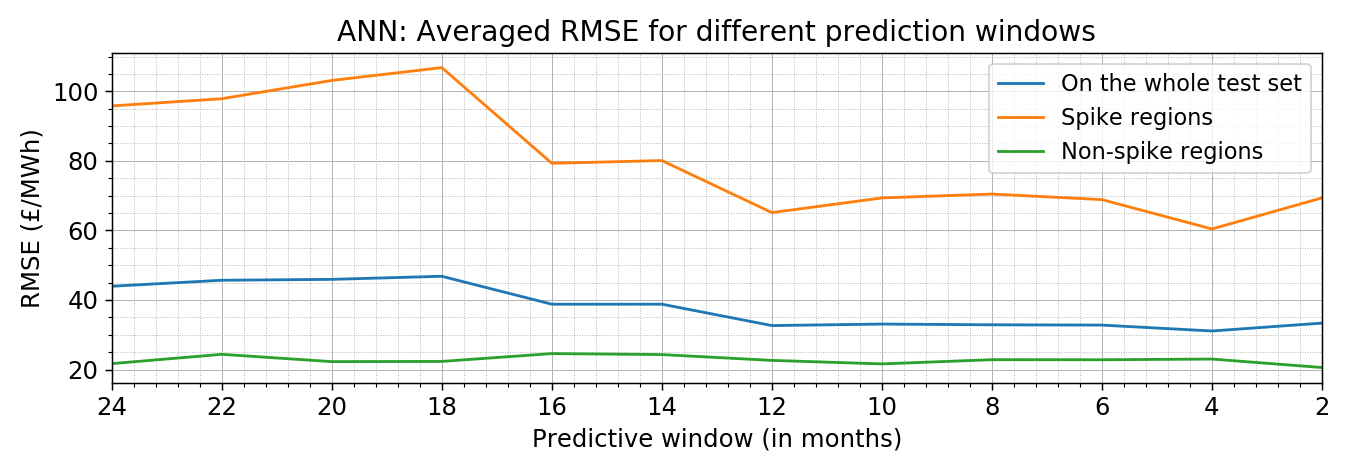

<IPython.core.display.Javascript object>


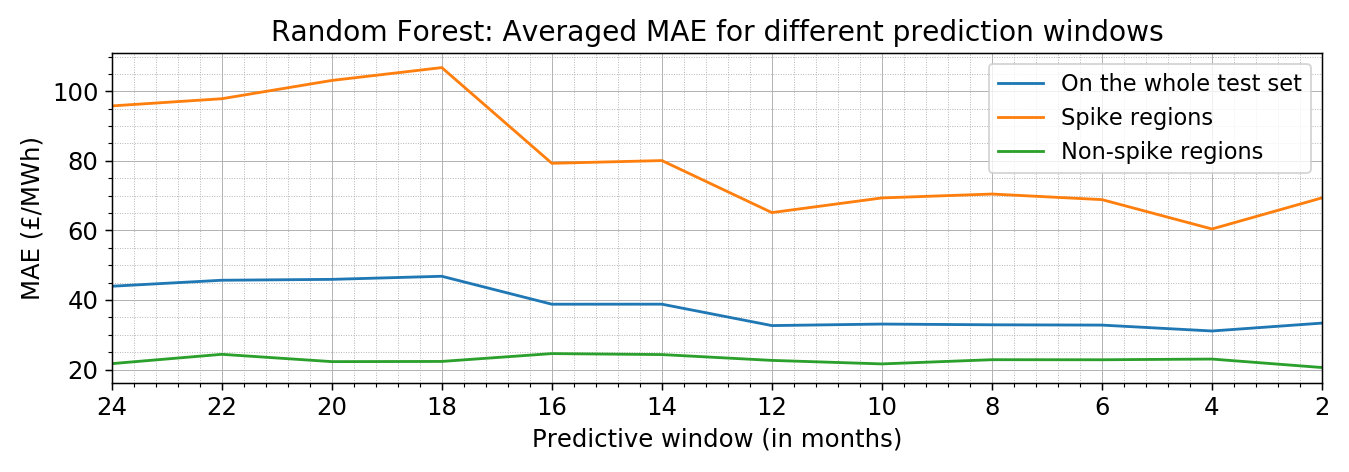

In [12]:
dates_labels = ['24 ', 
                '22 ',
                '20 ',  
                '18 ', 
                '16 ', 
                '14 ', 
                '12 ',
                '10 ',
                '8 ',
                '6 ',
                '4 ',
                '2 ']

fontsize = 13

plt.figure(figsize=(10,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('ANN: Averaged RMSE for different prediction windows', fontsize = fontsize + 2)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_gen, label = 'On the whole test set')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_spi, label = 'Spike regions')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_nor, label = 'Non-spike regions')
plt.legend(loc = 'upper right', fontsize = fontsize - 1)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xlabel('Predictive window (in months)', fontsize = fontsize)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], list(np.arange(2, 26, 2))[::-1], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, 11)
plt.tight_layout()
plt.savefig('RMSE_predictive_window.png')

plt.figure(figsize=(10,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Random Forest: Averaged MAE for different prediction windows', fontsize = fontsize + 2)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_gen, label = 'On the whole test set')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_spi, label = 'Spike regions')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_nor, label = 'Non-spike regions')
plt.legend(loc = 'upper right', fontsize = fontsize - 1)
plt.ylabel('MAE (£/MWh)', fontsize = fontsize)
plt.xlabel('Predictive window (in months)', fontsize = fontsize)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], list(np.arange(2, 26, 2))[::-1], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, 11)
plt.tight_layout()
plt.savefig('MAE_predictive_window.png')